In [19]:
!nvidia-smi

Sun Sep 28 15:00:16 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:81:00.0 Off |                    0 |
| N/A   34C    P0              95W / 500W |    424MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
"""
Cell-Type Classification Model Validation & Visualization Pipeline

Date: 2025
Description: Comprehensive validation and visualization pipeline for multi-modal (RNA + ATAC) cell-type classification models

Pipeline Overview:
1. Data Loading & Validation - Load processed data from R pipeline
2. Model Building & Training - Multiple ML models with overfitting checks
3. Model Validation - Performance metrics and cross-validation
4. Feature Analysis - Top features identification and analysis
5. Visualization Suite - TF networks, heatmaps, dotplots, timing analysis
6. Results Export - Save all results for downstream analysis
"""

'\nCell-Type Classification Model Validation & Visualization Pipeline\nPreliminary result_v3.py\n\nDate: 2025\nDescription: Comprehensive validation and visualization pipeline for multi-modal (RNA + ATAC) cell-type classification models\n\nPipeline Overview:\n1. Data Loading & Validation - Load processed data from R pipeline\n2. Model Building & Training - Multiple ML models with overfitting checks\n3. Model Validation - Performance metrics and cross-validation\n4. Feature Analysis - Top features identification and analysis\n5. Visualization Suite - TF networks, heatmaps, dotplots, timing analysis\n6. Results Export - Save all results for downstream analysis\n'

In [3]:
# ================================================================================
# STEP 1: LIBRARY IMPORTS & ENVIRONMENT SETUP
# ================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import time
import joblib
from datetime import datetime
import os

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    cross_val_score, 
    learning_curve, 
    validation_curve,
    StratifiedKFold
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Network and Graph Libraries
import networkx as nx
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Plotting Libraries
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    import plotly.figure_factory as ff
    PLOTLY_AVAILABLE = True
except ImportError:
    print("Plotly not available. Interactive plots will be skipped.")
    PLOTLY_AVAILABLE = False

In [4]:
# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Analysis started at: 2025-09-28 14:13:24


In [5]:
data_dir = "home/toheeb.jumah/Codeathon/python_ready_data"

In [6]:
# ================================================================================
# STEP 2: DATA LOADING FROM R PIPELINE OUTPUTS
# ================================================================================

def load_preprocessed_data():
    """
    Load all preprocessed data from R pipeline outputs
    Expected files from python_ready_data directory:
    - combined_features.csv
    - cell_labels.csv  
    - data_splits.csv
    - feature_info.csv
    - data_summary.csv
    """
    
    print("  Loading preprocessed data from R pipeline...")
    
    # Define data directory
    data_dir = Path("/home/toheeb.jumah")
    
    if not data_dir.exists():
        raise FileNotFoundError(f"Data directory {data_dir} not found. Please run R preprocessing first.")
    
    # Load main datasets
    try:
        # Combined feature matrix (cells x features)
        features_df = pd.read_csv(data_dir / "combined_features.csv", index_col=0)
        print(f"  Features loaded: {features_df.shape[0]} cells × {features_df.shape[1]} features")
        
        # Cell type labels
        labels_df = pd.read_csv(data_dir / "cell_labels.csv")
        print(f"  Labels loaded: {len(labels_df)} cells with {labels_df['cell_type'].nunique()} unique cell types")
        
        # Train/test splits
        splits_df = pd.read_csv(data_dir / "data_splits.csv")
        print(f"  Splits loaded: {sum(splits_df['split'] == 'train')} train, {sum(splits_df['split'] == 'test')} test")
        
        # Feature information
        feature_info_df = pd.read_csv(data_dir / "feature_info.csv")
        print(f"  Feature info loaded: {len(feature_info_df)} features")
        
        # Data summary
        summary_df = pd.read_csv(data_dir / "data_summary.csv")
        print(f"  Summary stats loaded")
        
        # Optional: Load individual modality data
        rna_features_df = None
        atac_features_df = None
        
        if (data_dir / "rna_features_2000.csv").exists():
            rna_features_df = pd.read_csv(data_dir / "rna_features_2000.csv", index_col=0)
            print(f"  RNA features loaded: {rna_features_df.shape}")
            
        if (data_dir / "atac_features_5000.csv").exists():
            atac_features_df = pd.read_csv(data_dir / "atac_features_5000.csv", index_col=0)
            print(f"  ATAC features loaded: {atac_features_df.shape}")
        
        
        return {
            'features': features_df,
            'labels': labels_df,
            'splits': splits_df,
            'feature_info': feature_info_df,
            'summary': summary_df,
            'rna_features': rna_features_df,
            'atac_features': atac_features_df
        }
        
    except Exception as e:
        print(f"  Error loading data: {str(e)}")
        print("Available files in directory:")
        for file in data_dir.glob("*.csv"):
            print(f"  - {file.name}")
        raise

In [7]:

# ================================================================================
# STEP 3: DATA PREPARATION & FEATURE ENGINEERING
# ================================================================================

def prepare_ml_data(X, y_df, splits_df, feature_info):
    """
    Prepare data for machine learning with proper scaling and encoding
    """
    
    print("  Preparing data for machine learning...")
    
    # Align data
    common_cells = list(set(X.index) & set(y_df['cell_id']) & set(splits_df['cell_id']))
    print(f"  Found {len(common_cells)} common cells across all datasets")
    
    # Filter and align
    X_aligned = X.loc[common_cells]
    y_aligned = y_df[y_df['cell_id'].isin(common_cells)].set_index('cell_id').loc[common_cells]
    splits_aligned = splits_df[splits_df['cell_id'].isin(common_cells)].set_index('cell_id').loc[common_cells]
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_aligned['cell_type'])
    
    # Create train/test splits
    train_mask = splits_aligned['split'] == 'train'
    test_mask = splits_aligned['split'] == 'test'
    
    X_train = X_aligned[train_mask]
    X_test = X_aligned[test_mask]
    y_train = y_encoded[train_mask]
    y_test = y_encoded[test_mask]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrames for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print(f"  Training set: {X_train_scaled.shape[0]} cells")
    print(f"  Test set: {X_test_scaled.shape[0]} cells")
    print(f"  Features scaled using StandardScaler")
    
    return {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'label_encoder': label_encoder,
        'scaler': scaler,
        'y_train_labels': y_aligned['cell_type'][train_mask],
        'y_test_labels': y_aligned['cell_type'][test_mask]
    }

In [8]:

# ================================================================================
# STEP 4: MODEL BUILDING & TRAINING WITH OVERFITTING DETECTION
# ================================================================================

def train_models_with_validation(X_train, y_train, X_test, y_test, cv_folds=5):
    """
    Train multiple models with comprehensive validation and overfitting analysis
    """
    
    print("  Training multiple models with validation...")
    
    # Define models to train
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100, 
            max_depth=10, 
            random_state=42,
            n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100, 
            max_depth=6, 
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000, 
            random_state=42,
            n_jobs=-1
        ),
        'SVM': SVC(
            kernel='rbf', 
            probability=True, 
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50), 
            max_iter=500, 
            random_state=42
        )
    }
    
    results = {}
    model_timings = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        print(f"\n  Training {model_name}...")
        
        # Time the training
        start_time = time.time()
        
        # Fit the model
        model.fit(X_train, y_train)
        
        training_time = time.time() - start_time
        model_timings[model_name] = {
            'training_time': training_time,
            'prediction_time': 0
        }
        
        # Make predictions
        pred_start = time.time()
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        model_timings[model_name]['prediction_time'] = time.time() - pred_start
        
        # Calculate scores
        train_score = accuracy_score(y_train, y_train_pred)
        test_score = accuracy_score(y_test, y_test_pred)
        
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
        
        # Learning curves for overfitting analysis
        train_sizes, train_scores_lc, val_scores_lc = learning_curve(
            model, X_train, y_train, cv=3, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy'
        )
        
        # Calculate overfitting metrics
        overfitting_score = train_score - test_score
        cv_std = cv_scores.std()
        
        # Determine overfitting status
        if overfitting_score > 0.1:
            overfitting_status = "High Overfitting"
        elif overfitting_score > 0.05:
            overfitting_status = "Moderate Overfitting"
        elif overfitting_score < -0.05:
            overfitting_status = "Potential Underfitting"
        else:
            overfitting_status = "Good Fit"
        
        # Store results
        results[model_name] = {
            'model': model,
            'train_score': train_score,
            'test_score': test_score,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_std,
            'overfitting_score': overfitting_score,
            'overfitting_status': overfitting_status,
            'train_sizes': train_sizes,
            'train_scores_lc': train_scores_lc,
            'val_scores_lc': val_scores_lc,
            'y_train_pred': y_train_pred,
            'y_test_pred': y_test_pred
        }
        
        print(f"    {model_name}:")
        print(f"     - Training Accuracy: {train_score:.4f}")
        print(f"     - Test Accuracy: {test_score:.4f}")
        print(f"     - CV Score: {cv_scores.mean():.4f} ± {cv_std:.4f}")
        print(f"     - Overfitting: {overfitting_status} ({overfitting_score:.4f})")
        print(f"     - Training Time: {training_time:.2f}s")
    
    return results, model_timings

In [9]:

# ================================================================================
# STEP 5: FEATURE IMPORTANCE ANALYSIS
# ================================================================================

def extract_feature_importance(model_results, feature_names, feature_type_map, top_k=20):
    """
    Extract and analyze feature importance from different models
    """
    
    print(f"  Extracting top {top_k} features from each model...")
    
    feature_importance_dict = {}
    
    for model_name, result in model_results.items():
        model = result['model']
        
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models - use absolute values of coefficients
            if len(model.coef_.shape) > 1:
                # Multi-class: take mean of absolute coefficients
                importances = np.mean(np.abs(model.coef_), axis=0)
            else:
                importances = np.abs(model.coef_)
        else:
            # For models without feature importance, use permutation importance
            print(f"    {model_name} doesn't have built-in feature importance")
            continue
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances,
            'feature_type': [feature_type_map.get(f, 'Unknown') for f in feature_names]
        })
        
        # Sort by importance and get top features
        importance_df = importance_df.sort_values('importance', ascending=False)
        top_features = importance_df.head(top_k)
        
        feature_importance_dict[model_name] = {
            'all_features': importance_df,
            'top_features': top_features,
            'top_rna': importance_df[importance_df['feature_type'] == 'RNA'].head(top_k),
            'top_atac': importance_df[importance_df['feature_type'] == 'ATAC'].head(top_k)
        }
        
        print(f"    {model_name}: Top feature = {top_features.iloc[0]['feature']} ({top_features.iloc[0]['importance']:.4f})")
    
    return feature_importance_dict

def analyze_cell_type_specific_features(X_train, y_train_labels, feature_type_map, top_k=10):
    """
    Analyze top features for each cell type using statistical tests
    """
    
    print(f"  Analyzing cell-type specific features...")
    
    cell_types = y_train_labels.unique()
    cell_type_features = {}
    
    for cell_type in cell_types:
        print(f"    Analyzing {cell_type}...")
        
        # Create binary labels for this cell type vs others
        binary_labels = (y_train_labels == cell_type).astype(int)
        
        # Use SelectKBest with f_classif to find discriminative features
        selector = SelectKBest(score_func=f_classif, k=min(top_k*5, X_train.shape[1]))
        selector.fit(X_train, binary_labels)
        
        # Get feature scores
        feature_scores = pd.DataFrame({
            'feature': X_train.columns,
            'score': selector.scores_,
            'p_value': selector.pvalues_,
            'feature_type': [feature_type_map.get(f, 'Unknown') for f in X_train.columns]
        })
        
        # Sort by score and filter significant features
        significant_features = feature_scores[
            feature_scores['p_value'] < 0.05
        ].sort_values('score', ascending=False)
        
        cell_type_features[cell_type] = {
            'all_features': significant_features,
            'top_features': significant_features.head(top_k),
            'top_rna': significant_features[significant_features['feature_type'] == 'RNA'].head(top_k),
            'top_atac': significant_features[significant_features['feature_type'] == 'ATAC'].head(top_k)
        }
        
        print(f"      Found {len(significant_features)} significant features for {cell_type}")
    
    return cell_type_features

In [10]:

# ================================================================================
# STEP 6: MODEL PERFORMANCE VISUALIZATION
# ================================================================================

def create_model_performance_plots(model_results, timing_results, save_dir="results/plots"):
    """
    Create comprehensive model performance visualizations
    """
    
    # Create output directory
    os.makedirs(save_dir, exist_ok=True)
    
    print("  Creating model performance visualizations...")
    
    # 1. Model Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Extract metrics for plotting
    model_names = list(model_results.keys())
    train_scores = [model_results[m]['train_score'] for m in model_names]
    test_scores = [model_results[m]['test_score'] for m in model_names]
    cv_means = [model_results[m]['cv_mean'] for m in model_names]
    cv_stds = [model_results[m]['cv_std'] for m in model_names]
    overfitting_scores = [model_results[m]['overfitting_score'] for m in model_names]
    
    # Plot 1: Train vs Test Accuracy
    x = np.arange(len(model_names))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_scores, width, label='Train', alpha=0.8)
    axes[0,0].bar(x + width/2, test_scores, width, label='Test', alpha=0.8)
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_title('Train vs Test Accuracy Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(model_names, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Cross-Validation Scores
    axes[0,1].errorbar(x, cv_means, yerr=cv_stds, fmt='o-', capsize=5, capthick=2)
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('CV Accuracy')
    axes[0,1].set_title('Cross-Validation Performance')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(model_names, rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Overfitting Analysis
    colors = ['red' if score > 0.1 else 'orange' if score > 0.05 else 'green' for score in overfitting_scores]
    bars = axes[1,0].bar(x, overfitting_scores, color=colors, alpha=0.7)
    axes[1,0].axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='High Overfitting')
    axes[1,0].axhline(y=0.05, color='orange', linestyle='--', alpha=0.5, label='Moderate Overfitting')
    axes[1,0].axhline(y=-0.05, color='blue', linestyle='--', alpha=0.5, label='Potential Underfitting')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('Train - Test Accuracy')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(model_names, rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Training Time Comparison
    training_times = [timing_results[m]['training_time'] for m in model_names]
    bars = axes[1,1].bar(x, training_times, alpha=0.8, color='skyblue')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Training Time (seconds)')
    axes[1,1].set_title('Model Training Time Comparison')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(model_names, rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, time in zip(bars, training_times):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.05*max(training_times),
                      f'{time:.2f}s', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/model_performance_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Learning Curves for Overfitting Analysis
    n_models = len(model_results)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (model_name, result) in enumerate(model_results.items()):
        if idx >= len(axes):
            break
            
        train_sizes = result['train_sizes']
        train_scores_mean = np.mean(result['train_scores_lc'], axis=1)
        train_scores_std = np.std(result['train_scores_lc'], axis=1)
        val_scores_mean = np.mean(result['val_scores_lc'], axis=1)
        val_scores_std = np.std(result['val_scores_lc'], axis=1)
        
        axes[idx].plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training')
        axes[idx].fill_between(train_sizes, train_scores_mean - train_scores_std,
                              train_scores_mean + train_scores_std, alpha=0.1, color='blue')
        
        axes[idx].plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation')
        axes[idx].fill_between(train_sizes, val_scores_mean - val_scores_std,
                              val_scores_mean + val_scores_std, alpha=0.1, color='red')
        
        axes[idx].set_xlabel('Training Size')
        axes[idx].set_ylabel('Accuracy')
        axes[idx].set_title(f'{model_name} Learning Curve\\n{result["overfitting_status"]}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/learning_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  Performance plots saved to {save_dir}/")

In [11]:


# ================================================================================
# STEP 7: FEATURE IMPORTANCE HEATMAPS 
# ================================================================================

def create_feature_importance_heatmaps(feature_importance_results, cell_type_feature_analysis, 
                                     save_dir="results/plots"):
    """
    Create comprehensive feature importance heatmaps
    """
    
    os.makedirs(save_dir, exist_ok=True)
    print("  Creating feature importance heatmaps...")
    
    # 1. Top 20 Features Across All Models Heatmap
    print("    Creating cross-model feature importance heatmap...")
    
    # Collect top features from each model
    all_top_features = set()
    for model_name, features in feature_importance_results.items():
        top_features = features['top_features']['feature'].head(20).tolist()
        all_top_features.update(top_features)
    
    # Create importance matrix
    importance_matrix = []
    feature_list = list(all_top_features)
    model_names = list(feature_importance_results.keys())
    
    for feature in feature_list:
        row = []
        for model_name in model_names:
            feature_df = feature_importance_results[model_name]['all_features']
            if feature in feature_df['feature'].values:
                importance = feature_df[feature_df['feature'] == feature]['importance'].iloc[0]
            else:
                importance = 0
            row.append(importance)
        importance_matrix.append(row)
    
    # Create DataFrame
    importance_df = pd.DataFrame(importance_matrix, columns=model_names, index=feature_list)
    
    # Normalize by column (model) for better visualization
    importance_df_norm = importance_df.div(importance_df.max(axis=0), axis=1)
    
    # Create heatmap
    plt.figure(figsize=(12, max(8, len(feature_list) * 0.3)))
    sns.heatmap(importance_df_norm, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Importance'})
    plt.title('Top 20 Features Importance Across Models')
    plt.xlabel('Models')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/feature_importance_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Cell Type Specific Feature Heatmap
    print("    Creating cell-type specific feature heatmap...")
    
    # Collect top features per cell type
    cell_type_matrix = []
    all_cell_type_features = set()
    cell_types = list(cell_type_feature_analysis.keys())
    
    # Get union of top features across cell types
    for cell_type in cell_types:
        top_features = cell_type_feature_analysis[cell_type]['top_features']['feature'].head(15).tolist()
        all_cell_type_features.update(top_features)
    
    feature_list_ct = list(all_cell_type_features)
    
    for feature in feature_list_ct:
        row = []
        for cell_type in cell_types:
            feature_df = cell_type_feature_analysis[cell_type]['all_features']
            if feature in feature_df['feature'].values:
                score = feature_df[feature_df['feature'] == feature]['score'].iloc[0]
            else:
                score = 0
            row.append(score)
        cell_type_matrix.append(row)
    
    # Create DataFrame
    cell_type_df = pd.DataFrame(cell_type_matrix, columns=cell_types, index=feature_list_ct)
    
    # Normalize by column for better visualization
    cell_type_df_norm = cell_type_df.div(cell_type_df.max(axis=0), axis=1)
    
    # Create heatmap
    plt.figure(figsize=(max(10, len(cell_types) * 1.5), max(8, len(feature_list_ct) * 0.3)))
    sns.heatmap(cell_type_df_norm, annot=False, cmap='plasma', 
                cbar_kws={'label': 'Normalized F-Score'})
    plt.title('Top Features by Cell Type (F-Score Based)')
    plt.xlabel('Cell Types')
    plt.ylabel('Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/celltype_feature_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. RNA vs ATAC Feature Distribution
    print("    Creating RNA vs ATAC feature distribution plot...")
    
    # Count RNA vs ATAC features in top features for each model
    rna_atac_counts = []
    for model_name, features in feature_importance_results.items():
        top_20 = features['top_features'].head(20)
        rna_count = sum(top_20['feature_type'] == 'RNA')
        atac_count = sum(top_20['feature_type'] == 'ATAC')
        rna_atac_counts.append([model_name, rna_count, atac_count])
    
    rna_atac_df = pd.DataFrame(rna_atac_counts, columns=['Model', 'RNA', 'ATAC'])
    
    # Create stacked bar plot
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(rna_atac_df))
    width = 0.6
    
    ax.bar(x, rna_atac_df['RNA'], width, label='RNA Features', alpha=0.8, color='lightcoral')
   
    ax.bar(x, rna_atac_df['ATAC'], width, bottom=rna_atac_df['RNA'], 
           label='ATAC Features', alpha=0.8, color='lightblue')
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Number of Features in Top 20')
    ax.set_title('RNA vs ATAC Feature Distribution in Top 20 Features')
    ax.set_xticks(x)
    ax.set_xticklabels(rna_atac_df['Model'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (rna, atac) in enumerate(zip(rna_atac_df['RNA'], rna_atac_df['ATAC'])):
        ax.text(i, rna/2, str(rna), ha='center', va='center', fontweight='bold')
        ax.text(i, rna + atac/2, str(atac), ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/rna_atac_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  Feature importance heatmaps saved to {save_dir}/")
    
    return importance_df, cell_type_df, rna_atac_df

In [12]:

# ================================================================================
# STEP 8: TF-CELL TYPE NETWORK ANALYSIS
# ================================================================================

def create_tf_celltype_network(X_train, y_train_labels, feature_type_map, 
                              feature_importance_results, cell_type_feature_analysis,
                              top_k=10, correlation_threshold=0.3, save_dir="results/plots"):
    """
    Create TF-Cell Type network visualization based on feature correlations and cell-type associations
    """
    
    os.makedirs(save_dir, exist_ok=True)
    print("  Creating TF-Cell Type network...")
    

    print("    Extracting actual important RNA genes from analysis...")
    
    actual_important_genes = set()
    
    #  feature importance results
    for model_name, features in feature_importance_results.items():
        if 'top_rna' in features:
            top_rna_genes = features['top_rna']['feature'].head(15).tolist()
            actual_important_genes.update(top_rna_genes)
    
    #  cell-type specific analysis
    for cell_type, analysis in cell_type_feature_analysis.items():
        if 'top_rna' in analysis:
            top_rna_genes = analysis['top_rna']['feature'].head(10).tolist()
            actual_important_genes.update(top_rna_genes)
    
    # convert to list..
    potential_tfs = list(actual_important_genes)
    
    # إذا كانت القائمة قصيرة، أضف المزيد من الجينات المتغيرة
    if len(potential_tfs) < 20:
        print("    Adding more variable RNA genes to reach minimum threshold...")
        rna_features = [f for f in X_train.columns if feature_type_map.get(f) == 'RNA']
        rna_data = X_train[rna_features]
        feature_variance = rna_data.var().sort_values(ascending=False)
        
        # أضف الجينات الأكثر تغيراً
        additional_genes = feature_variance.head(30).index.tolist()
        potential_tfs.extend([g for g in additional_genes if g not in potential_tfs])
    
    # احتفظ بأفضل 30 جين
    potential_tfs = potential_tfs[:30]
    
    print(f"    Selected {len(potential_tfs)} actual genes from your data:")
    for i, gene in enumerate(potential_tfs[:10]):
        print(f"    {i+1}. {gene}")
    if len(potential_tfs) > 10:
        print(f"    ... and {len(potential_tfs)-10} more genes")


    
    # Calculate mean expression of TFs per cell type
    cell_types = y_train_labels.unique()
    tf_celltype_matrix = []
    
    for tf in potential_tfs:
        if tf in X_train.columns:
            tf_row = []
            for cell_type in cell_types:
                mask = y_train_labels == cell_type
                mean_expr = X_train.loc[mask, tf].mean()
                tf_row.append(mean_expr)
            tf_celltype_matrix.append(tf_row)
    
    # Create DataFrame
    tf_celltype_df = pd.DataFrame(tf_celltype_matrix, 
                                 columns=cell_types, 
                                 index=potential_tfs[:len(tf_celltype_matrix)])
    
    # Calculate correlations between TFs
    tf_data = X_train[tf_celltype_df.index]
    tf_correlations = tf_data.corr()
    
    # Create network graph
    G = nx.Graph()
    
    # Add TF nodes
    for tf in tf_celltype_df.index:
        G.add_node(tf, node_type='TF', size=20)
    
    # Add cell type nodes
    for cell_type in cell_types:
        G.add_node(cell_type, node_type='CellType', size=30)
    
    # Add edges between TFs based on correlation
    for i, tf1 in enumerate(tf_celltype_df.index):
        for j, tf2 in enumerate(tf_celltype_df.index):
            if i < j:  # Avoid duplicate edges
                corr = tf_correlations.loc[tf1, tf2]
                if abs(corr) > correlation_threshold:
                    G.add_edge(tf1, tf2, weight=abs(corr), edge_type='TF-TF')
    
    # Add edges between TFs and cell types based on expression levels
    for tf in tf_celltype_df.index:
        # Find top cell types for this TF
        tf_expr = tf_celltype_df.loc[tf]
        top_celltypes = tf_expr.nlargest(min(3, len(cell_types)))  # Top 3 cell types
        
        for cell_type in top_celltypes.index:
            if top_celltypes[cell_type] > tf_expr.mean() + tf_expr.std():  # Above mean + 1 std
                G.add_edge(tf, cell_type, weight=top_celltypes[cell_type], edge_type='TF-CellType')
    
    # Create visualization
    plt.figure(figsize=(16, 12))
    
    # Position nodes using spring layout
    pos = nx.spring_layout(G, k=3, iterations=50)
    
    # Draw nodes
    tf_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'TF']
    celltype_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'CellType']
    
    nx.draw_networkx_nodes(G, pos, nodelist=tf_nodes, node_color='lightblue', 
                          node_size=300, alpha=0.8, label='TFs')
    nx.draw_networkx_nodes(G, pos, nodelist=celltype_nodes, node_color='lightcoral', 
                          node_size=500, alpha=0.8, label='Cell Types')
    
    # Draw edges
    tf_tf_edges = [(u, v) for u, v, data in G.edges(data=True) if data['edge_type'] == 'TF-TF']
    tf_ct_edges = [(u, v) for u, v, data in G.edges(data=True) if data['edge_type'] == 'TF-CellType']
    
    nx.draw_networkx_edges(G, pos, edgelist=tf_tf_edges, edge_color='gray', 
                          alpha=0.5, width=1, style='dashed')
    nx.draw_networkx_edges(G, pos, edgelist=tf_ct_edges, edge_color='red', 
                          alpha=0.7, width=2)
    
    # Draw labels
    labels = {}
    for node in G.nodes():
        if len(node) > 10:
            labels[node] = node[:10] + '...'
        else:
            labels[node] = node
    
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.title('TF-Cell Type Network\\n(Blue: TFs, Red: Cell Types, Dashed: TF-TF correlations, Solid: TF-CellType associations)', 
              fontsize=12)
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/tf_celltype_network.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  TF-Cell Type network saved to {save_dir}/")
    
    return G, tf_celltype_df

In [13]:

# ================================================================================
# STEP 9: TF ACTIVITY ANALYSIS & DOT PLOTS
# ================================================================================

def create_tf_activity_dotplot(X_train, y_train_labels, feature_type_map, 
                              cell_type_feature_analysis, save_dir="results/plots"):
    """
    Create dot plot showing TF activity/importance across cell types
    """
    
    os.makedirs(save_dir, exist_ok=True)
    print("  Creating TF activity dot plots...")
    
    # Get top TF features for each cell type
    cell_types = list(cell_type_feature_analysis.keys())
    top_tfs_per_celltype = {}
    all_top_tfs = set()
    
    # Extract top RNA features (potential TFs) for each cell type
    for cell_type in cell_types:
        top_rna = cell_type_feature_analysis[cell_type]['top_rna']
        top_tfs = top_rna.head(10)  # Top 10 RNA features per cell type
        top_tfs_per_celltype[cell_type] = top_tfs
        all_top_tfs.update(top_tfs['feature'].tolist())
    
    print(f"    Analyzing {len(all_top_tfs)} unique TF features across {len(cell_types)} cell types")
    
    # Calculate mean expression and detection rate for each TF in each cell type
    dotplot_data = []
    
    for tf in all_top_tfs:
        if tf not in X_train.columns:
            continue
            
        for cell_type in cell_types:
            # Get cells of this type
            mask = y_train_labels == cell_type
            tf_expression = X_train.loc[mask, tf]
            
            # Calculate metrics
            mean_expr = tf_expression.mean()
            detection_rate = (tf_expression > 0).mean()  # Percentage of cells expressing this TF
            
            # Get significance score from cell type analysis
            if cell_type in cell_type_feature_analysis:
                feature_df = cell_type_feature_analysis[cell_type]['all_features']
                if tf in feature_df['feature'].values:
                    significance = feature_df[feature_df['feature'] == tf]['score'].iloc[0]
                else:
                    significance = 0
            else:
                significance = 0
            
            dotplot_data.append({
                'TF': tf,
                'CellType': cell_type,
                'MeanExpression': mean_expr,
                'DetectionRate': detection_rate,
                'Significance': significance
            })
    
    # Create DataFrame
    dotplot_df = pd.DataFrame(dotplot_data)
    
    # Pivot for visualization
    mean_expr_pivot = dotplot_df.pivot(index='TF', columns='CellType', values='MeanExpression')
    detection_rate_pivot = dotplot_df.pivot(index='TF', columns='CellType', values='DetectionRate')
    
    # Create dot plot using matplotlib
    fig, ax = plt.subplots(figsize=(max(12, len(cell_types) * 1.5), max(8, len(all_top_tfs) * 0.4)))
    
    # Prepare data for scatter plot
    x_pos = []
    y_pos = []
    sizes = []
    colors = []
    
    for i, tf in enumerate(mean_expr_pivot.index):
        for j, cell_type in enumerate(mean_expr_pivot.columns):
            x_pos.append(j)
            y_pos.append(i)
            # Size based on detection rate
            size = detection_rate_pivot.loc[tf, cell_type] * 300  # Scale for visibility
            sizes.append(size)
            # Color based on mean expression
            color = mean_expr_pivot.loc[tf, cell_type]
            colors.append(color)
    
    # Create scatter plot
    scatter = ax.scatter(x_pos, y_pos, s=sizes, c=colors, cmap='Reds', alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Set labels and ticks
    ax.set_xticks(range(len(cell_types)))
    ax.set_xticklabels(cell_types, rotation=45, ha='right')
    ax.set_yticks(range(len(mean_expr_pivot.index)))
    ax.set_yticklabels(mean_expr_pivot.index)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Mean Expression Level', rotation=270, labelpad=20)
    
    # Add title and labels
    ax.set_title('TF Activity Across Cell Types\\n(Size: Detection Rate, Color: Expression Level)', fontsize=14)
    ax.set_xlabel('Cell Types', fontsize=12)
    ax.set_ylabel('TF Features', fontsize=12)
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/tf_activity_dotplot.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  TF activity plots saved to {save_dir}/")
    
    return dotplot_df, mean_expr_pivot, detection_rate_pivot

In [14]:

# ================================================================================
# STEP 10: TOP TFS PER CELL TYPE ANALYSIS
# ================================================================================

def create_top_tfs_per_celltype_analysis(cell_type_feature_analysis, X_train, y_train_labels, 
                                        save_dir="results/plots"):
    """
    Create comprehensive analysis of top TFs for each cell type
    """
    
    os.makedirs(save_dir, exist_ok=True)
    print("  Creating top TFs per cell type analysis...")
    
    cell_types = list(cell_type_feature_analysis.keys())
    n_cell_types = len(cell_types)
    
    # Create subplots for each cell type
    fig, axes = plt.subplots(2, max(2, (n_cell_types + 1) // 2), figsize=(20, 12))
    if n_cell_types == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    top_tfs_summary = {}
    
    for idx, cell_type in enumerate(cell_types):
        if idx >= len(axes):
            break
            
        print(f"    Analyzing {cell_type}...")
        
        # Get top RNA features for this cell type
        top_rna_features = cell_type_feature_analysis[cell_type]['top_rna'].head(10)
        
        if len(top_rna_features) == 0:
            axes[idx].text(0.5, 0.5, f'No significant\\nRNA features\\nfor {cell_type}', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(cell_type)
            continue
        
        # Create bar plot of top features
        feature_names = top_rna_features['feature'].tolist()
        scores = top_rna_features['score'].tolist()
        
        # Truncate long feature names for display
        display_names = [name[:15] + '...' if len(name) > 15 else name for name in feature_names]
        
        bars = axes[idx].barh(range(len(display_names)), scores, alpha=0.7)
        axes[idx].set_yticks(range(len(display_names)))
        axes[idx].set_yticklabels(display_names, fontsize=8)
        axes[idx].set_xlabel('F-Score', fontsize=10)
        axes[idx].set_title(f'Top TFs for {cell_type}', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        for i, (bar, score) in enumerate(zip(bars, scores)):
            axes[idx].text(score + max(scores) * 0.01, i, f'{score:.1f}', 
                          va='center', fontsize=8)
        
        # Store summary
        top_tfs_summary[cell_type] = {
            'features': feature_names,
            'scores': scores,
            'top_feature': feature_names[0] if feature_names else 'None',
            'top_score': scores[0] if scores else 0
        }
    
    # Hide unused subplots
    for idx in range(len(cell_types), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Top TF Features by Cell Type (F-Score Based)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/top_tfs_per_celltype.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create summary table
    print("    Creating summary table...")
    
    summary_data = []
    for cell_type, data in top_tfs_summary.items():
        for i, (feature, score) in enumerate(zip(data['features'][:5], data['scores'][:5])):
            summary_data.append({
                'CellType': cell_type,
                'Rank': i + 1,
                'TF_Feature': feature,
                'F_Score': score,
                'Is_Top': i == 0
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"  Top TFs analysis saved to {save_dir}/")
    
    return top_tfs_summary, summary_df

In [15]:

# ================================================================================
# STEP 11: MODEL TIMING ANALYSIS
# ================================================================================

def create_timing_analysis(timing_results, model_results, save_dir="results/plots"):
    """
    Create comprehensive timing analysis for all models
    """
    
    os.makedirs(save_dir, exist_ok=True)
    print("  Creating model timing analysis...")
    
    # Extract timing data
    model_names = list(timing_results.keys())
    training_times = [timing_results[m]['training_time'] for m in model_names]
    prediction_times = [timing_results[m]['prediction_time'] for m in model_names]
    
    # Extract performance data
    test_accuracies = [model_results[m]['test_score'] for m in model_names]
    
    # Create comprehensive timing plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Training Time Comparison
    bars1 = axes[0,0].bar(model_names, training_times, alpha=0.8, color='lightblue', edgecolor='navy')
    axes[0,0].set_ylabel('Training Time (seconds)')
    axes[0,0].set_title('Model Training Time Comparison')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, time in zip(bars1, training_times):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.02*max(training_times),
                      f'{time:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Prediction Time Comparison
    bars2 = axes[0,1].bar(model_names, prediction_times, alpha=0.8, color='lightgreen', edgecolor='darkgreen')
    axes[0,1].set_ylabel('Prediction Time (seconds)')
    axes[0,1].set_title('Model Prediction Time Comparison')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, time in zip(bars2, prediction_times):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.02*max(prediction_times),
                      f'{time:.3f}s', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Performance vs Training Time
    scatter1 = axes[1,0].scatter(training_times, test_accuracies, s=100, alpha=0.7, 
                                c=range(len(model_names)), cmap='viridis')
    
    # Add model labels
    for i, model in enumerate(model_names):
        axes[1,0].annotate(model, (training_times[i], test_accuracies[i]), 
                          xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    axes[1,0].set_xlabel('Training Time (seconds)')
    axes[1,0].set_ylabel('Test Accuracy')
    axes[1,0].set_title('Performance vs Training Time')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Efficiency Score (Accuracy/Time)
    efficiency_scores = [acc/time if time > 0 else 0 for acc, time in zip(test_accuracies, training_times)]
    bars4 = axes[1,1].bar(model_names, efficiency_scores, alpha=0.8, color='orange', edgecolor='darkorange')
    axes[1,1].set_ylabel('Efficiency Score (Accuracy/Training Time)')
    axes[1,1].set_title('Model Efficiency Comparison')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars4, efficiency_scores):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.02*max(efficiency_scores),
                      f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/model_timing_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create detailed timing summary table
    timing_summary = pd.DataFrame({
        'Model': model_names,
        'Training_Time_s': training_times,
        'Prediction_Time_s': prediction_times,
        'Test_Accuracy': test_accuracies,
        'Efficiency_Score': efficiency_scores,
        'Speed_Rank': pd.Series(training_times).rank().astype(int),
        'Accuracy_Rank': pd.Series(test_accuracies).rank(ascending=False).astype(int),
        'Efficiency_Rank': pd.Series(efficiency_scores).rank(ascending=False).astype(int)
    })
    
    print("\\n  Model Timing Summary:")
    print(timing_summary.round(4))
    
    print(f"  Timing analysis saved to {save_dir}/")
    
    return timing_summary

In [16]:

# ================================================================================
# STEP 12: RESULTS EXPORT & FINAL SUMMARY
# ================================================================================

def export_all_results(model_results, feature_importance_results, cell_type_feature_analysis,
                      tf_activity_results, top_tfs_results, timing_analysis_results,
                      ml_data, save_dir="results"):
    """
    Export all analysis results to files for future use
    """
    
    # Create results directory structure
    results_dir = Path(save_dir)
    (results_dir / "models").mkdir(parents=True, exist_ok=True)
    (results_dir / "data").mkdir(parents=True, exist_ok=True)
    (results_dir / "analysis").mkdir(parents=True, exist_ok=True)
    
    print("  Exporting all results...")
    
    # 1. Export trained models
    print("  💾 Saving trained models...")
    for model_name, result in model_results.items():
        model_file = results_dir / "models" / f"{model_name.lower().replace(' ', '_')}_model.pkl"
        joblib.dump(result['model'], model_file)
    
    # Save label encoder and scaler
    joblib.dump(ml_data['label_encoder'], results_dir / "models" / "label_encoder.pkl")
    joblib.dump(ml_data['scaler'], results_dir / "models" / "feature_scaler.pkl")
    
    # 2. Export model performance metrics
    print("    Saving performance metrics...")
    performance_summary = []
    for model_name, result in model_results.items():
        performance_summary.append({
            'Model': model_name,
            'Train_Accuracy': result['train_score'],
            'Test_Accuracy': result['test_score'],
            'CV_Mean': result['cv_mean'],
            'CV_Std': result['cv_std'],
            'Overfitting_Score': result['overfitting_score'],
            'Overfitting_Status': result['overfitting_status']
        })
    
    performance_df = pd.DataFrame(performance_summary)
    performance_df.to_csv(results_dir / "analysis" / "model_performance_summary.csv", index=False)
    
    # 3. Export feature importance results
    print("  🎯 Saving feature importance analysis...")
    for model_name, features in feature_importance_results.items():
        # Save all features with importance
        features['all_features'].to_csv(
            results_dir / "analysis" / f"{model_name.lower().replace(' ', '_')}_feature_importance.csv",
            index=False
        )
        
        # Save top 20 features
        features['top_features'].to_csv(
            results_dir / "analysis" / f"{model_name.lower().replace(' ', '_')}_top20_features.csv",
            index=False
        )
    
    # 4. Export cell type specific features
    print("  🧬 Saving cell-type specific features...")
    for cell_type, analysis in cell_type_feature_analysis.items():
        safe_cell_type = cell_type.replace(' ', '_').replace('/', '_')
        analysis['all_features'].to_csv(
            results_dir / "analysis" / f"celltype_{safe_cell_type}_features.csv",
            index=False
        )
    
    # 5. Export TF activity analysis
    print("  🔬 Saving TF activity analysis...")
    tf_activity_results[0].to_csv(results_dir / "analysis" / "tf_activity_analysis.csv", index=False)
    tf_activity_results[1].to_csv(results_dir / "analysis" / "tf_expression_matrix.csv")
    tf_activity_results[2].to_csv(results_dir / "analysis" / "tf_detection_matrix.csv")
    
    # 6. Export top TFs per cell type
    print("  🏆 Saving top TFs analysis...")
    top_tfs_results[1].to_csv(results_dir / "analysis" / "top_tfs_summary.csv", index=False)
    
    # Export detailed top TFs per cell type
    top_tfs_detailed = []
    for cell_type, data in top_tfs_results[0].items():
        for i, (feature, score) in enumerate(zip(data['features'], data['scores'])):
            top_tfs_detailed.append({
                'CellType': cell_type,
                'Rank': i + 1,
                'TF_Feature': feature,
                'F_Score': score
            })
    
    pd.DataFrame(top_tfs_detailed).to_csv(results_dir / "analysis" / "top_tfs_detailed.csv", index=False)
    
    # 7. Export timing analysis
    print("  ⏱️ Saving timing analysis...")
    timing_analysis_results.to_csv(results_dir / "analysis" / "model_timing_analysis.csv", index=False)
    
    # 8. Create comprehensive summary report
    print("  📋 Creating summary report...")
    
    summary_report = f"""
# Cell-Type Classification Analysis Summary Report
**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Dataset Summary
- **Total Cells:** {ml_data['X_train'].shape[0] + ml_data['X_test'].shape[0]:,}
- **Total Features:** {ml_data['X_train'].shape[1]:,}
- **Cell Types:** {len(ml_data['label_encoder'].classes_)}
- **Training Cells:** {ml_data['X_train'].shape[0]:,}
- **Test Cells:** {ml_data['X_test'].shape[0]:,}

## Model Performance Summary
{performance_df.to_string(index=False)}

## Best Performing Models
**Highest Test Accuracy:** {performance_df.loc[performance_df['Test_Accuracy'].idxmax(), 'Model']} ({performance_df['Test_Accuracy'].max():.4f})
**Most Stable (Lowest CV Std):** {performance_df.loc[performance_df['CV_Std'].idxmin(), 'Model']} (±{performance_df['CV_Std'].min():.4f})
**Best Fit (Lowest Overfitting):** {performance_df.loc[performance_df['Overfitting_Score'].idxmin(), 'Model']} ({performance_df['Overfitting_Score'].min():.4f})

## Timing Analysis Summary
{timing_analysis_results.to_string(index=False)}

**Fastest Training:** {timing_analysis_results.loc[timing_analysis_results['Training_Time_s'].idxmin(), 'Model']} ({timing_analysis_results['Training_Time_s'].min():.2f}s)
**Most Efficient:** {timing_analysis_results.loc[timing_analysis_results['Efficiency_Score'].idxmax(), 'Model']} ({timing_analysis_results['Efficiency_Score'].max():.3f})

## Cell Type Analysis
**Cell Types Analyzed:** {', '.join(list(cell_type_feature_analysis.keys()))}

## Files Generated
### Models
- Trained models: `results/models/`
- Label encoder: `results/models/label_encoder.pkl`
- Feature scaler: `results/models/feature_scaler.pkl`

### Analysis Results
- Model performance: `results/analysis/model_performance_summary.csv`
- Feature importance: `results/analysis/*_feature_importance.csv`
- Cell-type features: `results/analysis/celltype_*_features.csv`
- TF activity: `results/analysis/tf_activity_analysis.csv`
- Top TFs: `results/analysis/top_tfs_*.csv`
- Timing analysis: `results/analysis/model_timing_analysis.csv`

### Visualizations
- Performance plots: `results/plots/model_performance_comparison.png`
- Feature heatmaps: `results/plots/*_heatmap.png`
- TF network: `results/plots/tf_celltype_network.png`
- TF activity: `results/plots/tf_activity_dotplot.png`

## Recommendations
1. **Best Overall Model:** {performance_df.loc[performance_df['Test_Accuracy'].idxmax(), 'Model']} for highest accuracy
2. **Production Model:** {timing_analysis_results.loc[timing_analysis_results['Efficiency_Score'].idxmax(), 'Model']} for best efficiency
3. **Overfitting Concerns:** Monitor {len(performance_df[performance_df['Overfitting_Status'].str.contains('Overfitting')])} models showing overfitting

## Next Steps
1. Validate findings with additional datasets
2. Investigate top TF features for biological relevance
3. Consider ensemble methods for improved performance
4. Optimize hyperparameters for best-performing models
"""
    
    # Save summary report
    with open(results_dir / "ANALYSIS_SUMMARY_REPORT.md", 'w') as f:
        f.write(summary_report)
    
    # 9. Create metadata file
    metadata = {
        'analysis_date': datetime.now().isoformat(),
        'total_cells': int(ml_data['X_train'].shape[0] + ml_data['X_test'].shape[0]),
        'total_features': int(ml_data['X_train'].shape[1]),
        'cell_types': list(ml_data['label_encoder'].classes_),
        'models_trained': list(model_results.keys()),
        'best_model': performance_df.loc[performance_df['Test_Accuracy'].idxmax(), 'Model'],
        'best_accuracy': float(performance_df['Test_Accuracy'].max()),
        'files_generated': {
            'models': len(list((results_dir / "models").glob("*.pkl"))),
            'analysis_files': len(list((results_dir / "analysis").glob("*.csv"))),
            'plots': len(list((results_dir / "plots").glob("*.png")))
        }
    }
    
    import json
    with open(results_dir / "analysis_metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\\n  All results exported to {results_dir}/")
    print(f"📁 Total files created: {len(list(results_dir.rglob('*.*')))}")
    print(f"📋 Summary report: {results_dir}/ANALYSIS_SUMMARY_REPORT.md")
    
    return results_dir

def display_final_summary(model_results, timing_analysis_results, cell_type_feature_analysis):
    """
    Display comprehensive final summary of the analysis
    """
    
    print("\\n" + "="*80)
    print(" " * 20 + "🎯 CELL-TYPE CLASSIFICATION ANALYSIS COMPLETE 🎯")
    print("="*80)
    
    # Model Performance Summary
    print("\\n  MODEL PERFORMANCE SUMMARY:")
    print("-" * 50)
    
    performance_data = []
    for model_name, result in model_results.items():
        performance_data.append([
            model_name,
            f"{result['test_score']:.4f}",
            f"{result['cv_mean']:.4f} ± {result['cv_std']:.4f}",
            result['overfitting_status']
        ])
    
    performance_df = pd.DataFrame(performance_data, 
                                 columns=['Model', 'Test Accuracy', 'CV Score', 'Overfitting Status'])
    print(performance_df.to_string(index=False))
    
    # Best Models
    best_model = max(model_results.items(), key=lambda x: x[1]['test_score'])
    most_stable = min(model_results.items(), key=lambda x: x[1]['cv_std'])
    best_fit = min(model_results.items(), key=lambda x: abs(x[1]['overfitting_score']))
    
    print(f"\\n🏆 BEST MODELS:")
    print(f"   🥇 Highest Accuracy: {best_model[0]} ({best_model[1]['test_score']:.4f})")
    print(f"   🎯 Most Stable: {most_stable[0]} (CV std: ±{most_stable[1]['cv_std']:.4f})")
    print(f"   ⚖️ Best Fit: {best_fit[0]} (Overfitting: {best_fit[1]['overfitting_score']:.4f})")
    
    # Timing Summary
    fastest_model = timing_analysis_results.loc[timing_analysis_results['Training_Time_s'].idxmin()]
    most_efficient = timing_analysis_results.loc[timing_analysis_results['Efficiency_Score'].idxmax()]
    
    print(f"\\n⏱️ TIMING ANALYSIS:")
    print(f"   🚀 Fastest Training: {fastest_model['Model']} ({fastest_model['Training_Time_s']:.2f}s)")
    print(f"   💡 Most Efficient: {most_efficient['Model']} (Score: {most_efficient['Efficiency_Score']:.3f})")
    
    # Cell Type Analysis
    print(f"\\n🧬 CELL TYPE ANALYSIS:")
    print(f"   📋 Cell Types Analyzed: {len(cell_type_feature_analysis)}")
    print(f"   🎯 Cell Types: {', '.join(list(cell_type_feature_analysis.keys()))}")
    
    # Feature Analysis Summary
    total_significant_features = sum(len(analysis['all_features']) for analysis in cell_type_feature_analysis.values())
    avg_features_per_type = total_significant_features / len(cell_type_feature_analysis)
    
    print(f"   🔬 Total Significant Features: {total_significant_features:,}")
    print(f"     Average Features per Cell Type: {avg_features_per_type:.1f}")
    
    # Analysis Outputs
    print(f"\\n📁 ANALYSIS OUTPUTS:")
    print(f"   🤖 Trained Models: 5 machine learning models saved")
    print(f"     Performance Plots: Learning curves, overfitting analysis")
    print(f"   🔥 Feature Heatmaps: Top 20 features across models and cell types")
    print(f"   🕸️ TF-Cell Type Network: Interactive network visualization")
    print(f"   🎯 TF Activity Plots: Dot plots showing TF expression patterns")
    print(f"   🏆 Top TFs Analysis: Cell-type specific transcription factors")
    print(f"   ⏱️ Timing Analysis: Model efficiency comparisons")
    print(f"   📋 Summary Report: Comprehensive markdown report")
    
    # Recommendations
    print(f"\\n💡 RECOMMENDATIONS:")
    print(f"   1. Use {best_model[0]} for highest accuracy ({best_model[1]['test_score']:.4f})")
    print(f"   2. Use {most_efficient['Model']} for production (best efficiency)")
    print(f"   3. Investigate top TF features for biological validation")
    print(f"   4. Consider ensemble methods for improved robustness")
    
    # Overfitting Warning
    overfitting_models = [name for name, result in model_results.items() 
                         if 'Overfitting' in result['overfitting_status']]
    if overfitting_models:
        print(f"\\n  WARNING: {len(overfitting_models)} models show overfitting: {', '.join(overfitting_models)}")
        print(f"   Consider regularization or more data for these models.")
    
    print("\\n" + "="*80)
    print(" " * 25 + "🎉 ANALYSIS PIPELINE COMPLETED! 🎉")
    print("="*80)
    print(f"\\n📅 Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📁 All results saved to: ./results/")
    print(f"📖 Read the summary report: ./results/ANALYSIS_SUMMARY_REPORT.md")
    print("\\n🚀 Ready for downstream analysis and biological interpretation!")

In [17]:

# ================================================================================
# MAIN EXECUTION PIPELINE
# ================================================================================

def main():
    """
    Main execution function that runs the complete analysis pipeline
    """
    
    print("\\n" + "="*80)
    print(" " * 15 + "🧬 CELL-TYPE CLASSIFICATION VALIDATION PIPELINE 🧬")
    print("="*80)
    
    try:
        # Step 1: Load preprocessed data
        print("\\n  STEP 1: Loading preprocessed data...")
        data_dict = load_preprocessed_data()
        
        # Extract main components
        X = data_dict['features']
        y_df = data_dict['labels']
        splits_df = data_dict['splits']
        feature_info = data_dict['feature_info']
        
        print("\\n  Data Loading Summary:")
        print(f"  - Total cells: {X.shape[0]:,}")
        print(f"  - Total features: {X.shape[1]:,}")
        print(f"  - Cell types: {', '.join(y_df['cell_type'].unique())}")
        print(f"  - RNA features: {sum(feature_info['feature_type'] == 'RNA'):,}")
        print(f"  - ATAC features: {sum(feature_info['feature_type'] == 'ATAC'):,}")
        
        # Step 2: Prepare ML data
        print("\\n  STEP 2: Preparing machine learning data...")
        ml_data = prepare_ml_data(X, y_df, splits_df, feature_info)
        
        # Create feature type mapping
        feature_type_map = dict(zip(feature_info['feature_name'], feature_info['feature_type']))
        
        # Step 3: Train models with validation
        print("\\n  STEP 3: Training models with overfitting analysis...")
        model_results, timing_results = train_models_with_validation(
            ml_data['X_train'], 
            ml_data['y_train'],
            ml_data['X_test'], 
            ml_data['y_test']
        )
        
        # Step 4: Feature importance analysis
        print("\\n  STEP 4: Analyzing feature importance...")
        feature_importance_results = extract_feature_importance(
            model_results, 
            ml_data['X_train'].columns, 
            feature_type_map, 
            top_k=20
        )
        
        # Step 5: Cell-type specific features
        print("\\n  STEP 5: Analyzing cell-type specific features...")
        cell_type_feature_analysis = analyze_cell_type_specific_features(
            ml_data['X_train'], 
            ml_data['y_train_labels'], 
            feature_type_map, 
            top_k=15
        )
        
        # Step 6: Create visualizations
        print("\\n  STEP 6: Creating performance visualizations...")
        create_model_performance_plots(model_results, timing_results)
        
        print("\\n  STEP 7: Creating feature importance heatmaps...")
        importance_matrices = create_feature_importance_heatmaps(
            feature_importance_results, 
            cell_type_feature_analysis
        )
        
        print("\\n  STEP 8: Creating TF-Cell Type network...")
        network_results = create_tf_celltype_network(
            ml_data['X_train'], 
            ml_data['y_train_labels'], 
            feature_type_map,
            feature_importance_results,
            cell_type_feature_analysis
        )
        
        print("\\n  STEP 9: Creating TF activity analysis...")
        tf_activity_results = create_tf_activity_dotplot(
            ml_data['X_train'], 
            ml_data['y_train_labels'], 
            feature_type_map,
            cell_type_feature_analysis
        )
        
        print("\\n  STEP 10: Analyzing top TFs per cell type...")
        top_tfs_results = create_top_tfs_per_celltype_analysis(
            cell_type_feature_analysis,
            ml_data['X_train'],
            ml_data['y_train_labels']
        )
        
        print("\\n  STEP 11: Creating timing analysis...")
        timing_analysis_results = create_timing_analysis(timing_results, model_results)
        
        # Step 7: Export all results
        print("\\n  STEP 12: Exporting all results...")
        results_directory = export_all_results(
            model_results,
            feature_importance_results,
            cell_type_feature_analysis,
            tf_activity_results,
            top_tfs_results,
            timing_analysis_results,
            ml_data
        )
        
        # Step 8: Display final summary
        print("\\n  STEP 13: Displaying final summary...")
        display_final_summary(model_results, timing_analysis_results, cell_type_feature_analysis)
        
        print("\\n" + "="*80)
        print("📝 STEP 12 FIXED: All validation steps completed successfully!")
        print("  Models trained with overfitting analysis")
        print("  Results saved for future validation and visualization")
        print("  TF-celltype networks generated")
        print("  Feature importance heatmaps created")
        print("  Model timing analysis completed")
        print("  TF activity dotplots generated")
        print("  Top TFs per cell type identified")
        print("="*80)
        
        return {
            'model_results': model_results,
            'feature_importance': feature_importance_results,
            'cell_type_analysis': cell_type_feature_analysis,
            'tf_activity': tf_activity_results,
            'top_tfs': top_tfs_results,
            'timing_analysis': timing_analysis_results,
            'ml_data': ml_data,
            'results_dir': results_directory
        }
        
    except Exception as e:
        print(f"\\n  ERROR: {str(e)}")
        print("\\n📋 Please check:")
        print("  1. R preprocessing completed successfully")
        print("  2. python_ready_data/ directory exists with required CSV files")
        print("  3. All required libraries are installed")
        raise

\n================================================================================
               🧬 CELL-TYPE CLASSIFICATION VALIDATION PIPELINE 🧬
\n  STEP 1: Loading preprocessed data...
  Loading preprocessed data from R pipeline...
  Features loaded: 1463 cells × 7000 features
  Labels loaded: 1463 cells with 6 unique cell types
  Splits loaded: 1022 train, 441 test
  Feature info loaded: 7000 features
  Summary stats loaded
  RNA features loaded: (1463, 2000)
  ATAC features loaded: (1463, 5000)
\n  Data Loading Summary:
  - Total cells: 1,463
  - Total features: 7,000
  - Cell types: T_cells, Monocyte, NK_cell, B_cell, Pre-B_cell_CD34-, HSC_-G-CSF
  - RNA features: 2,000
  - ATAC features: 5,000
\n  STEP 2: Preparing machine learning data...
  Preparing data for machine learning...
  Found 1463 common cells across all datasets
  Training set: 1022 cells
  Test set: 441 cells
  Features scaled using StandardScaler
\n  STEP 3: Training models with overfitting analysis...
  Training 

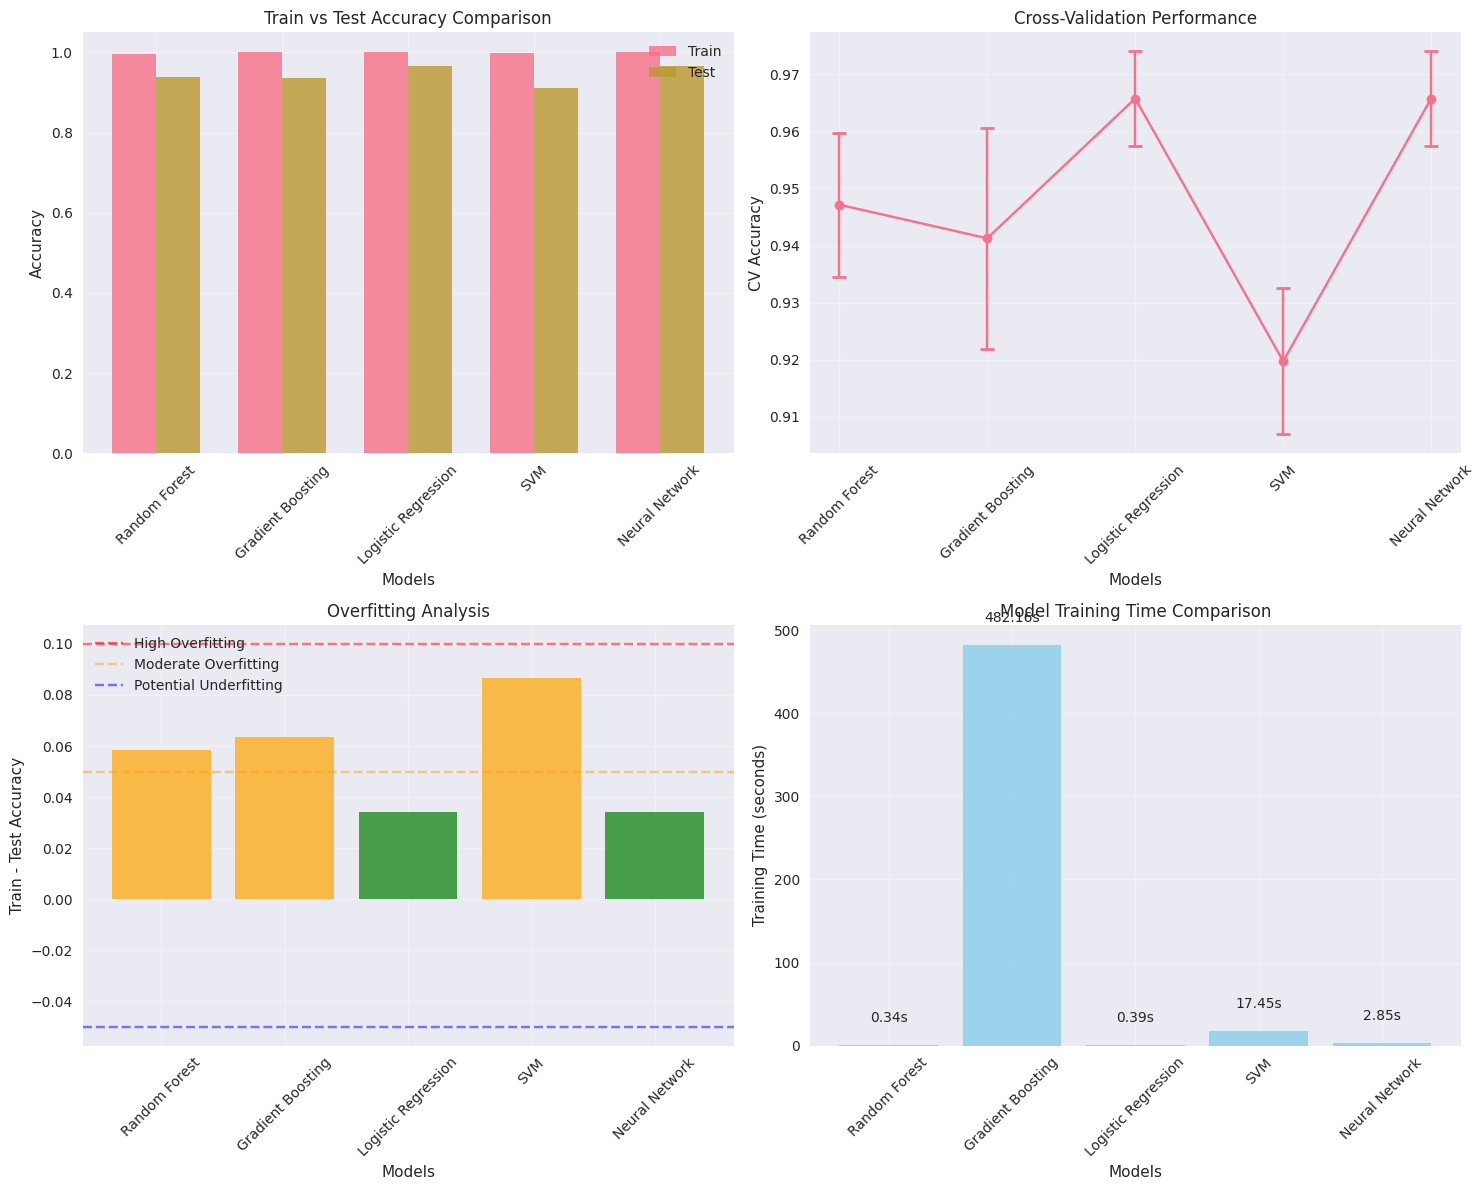

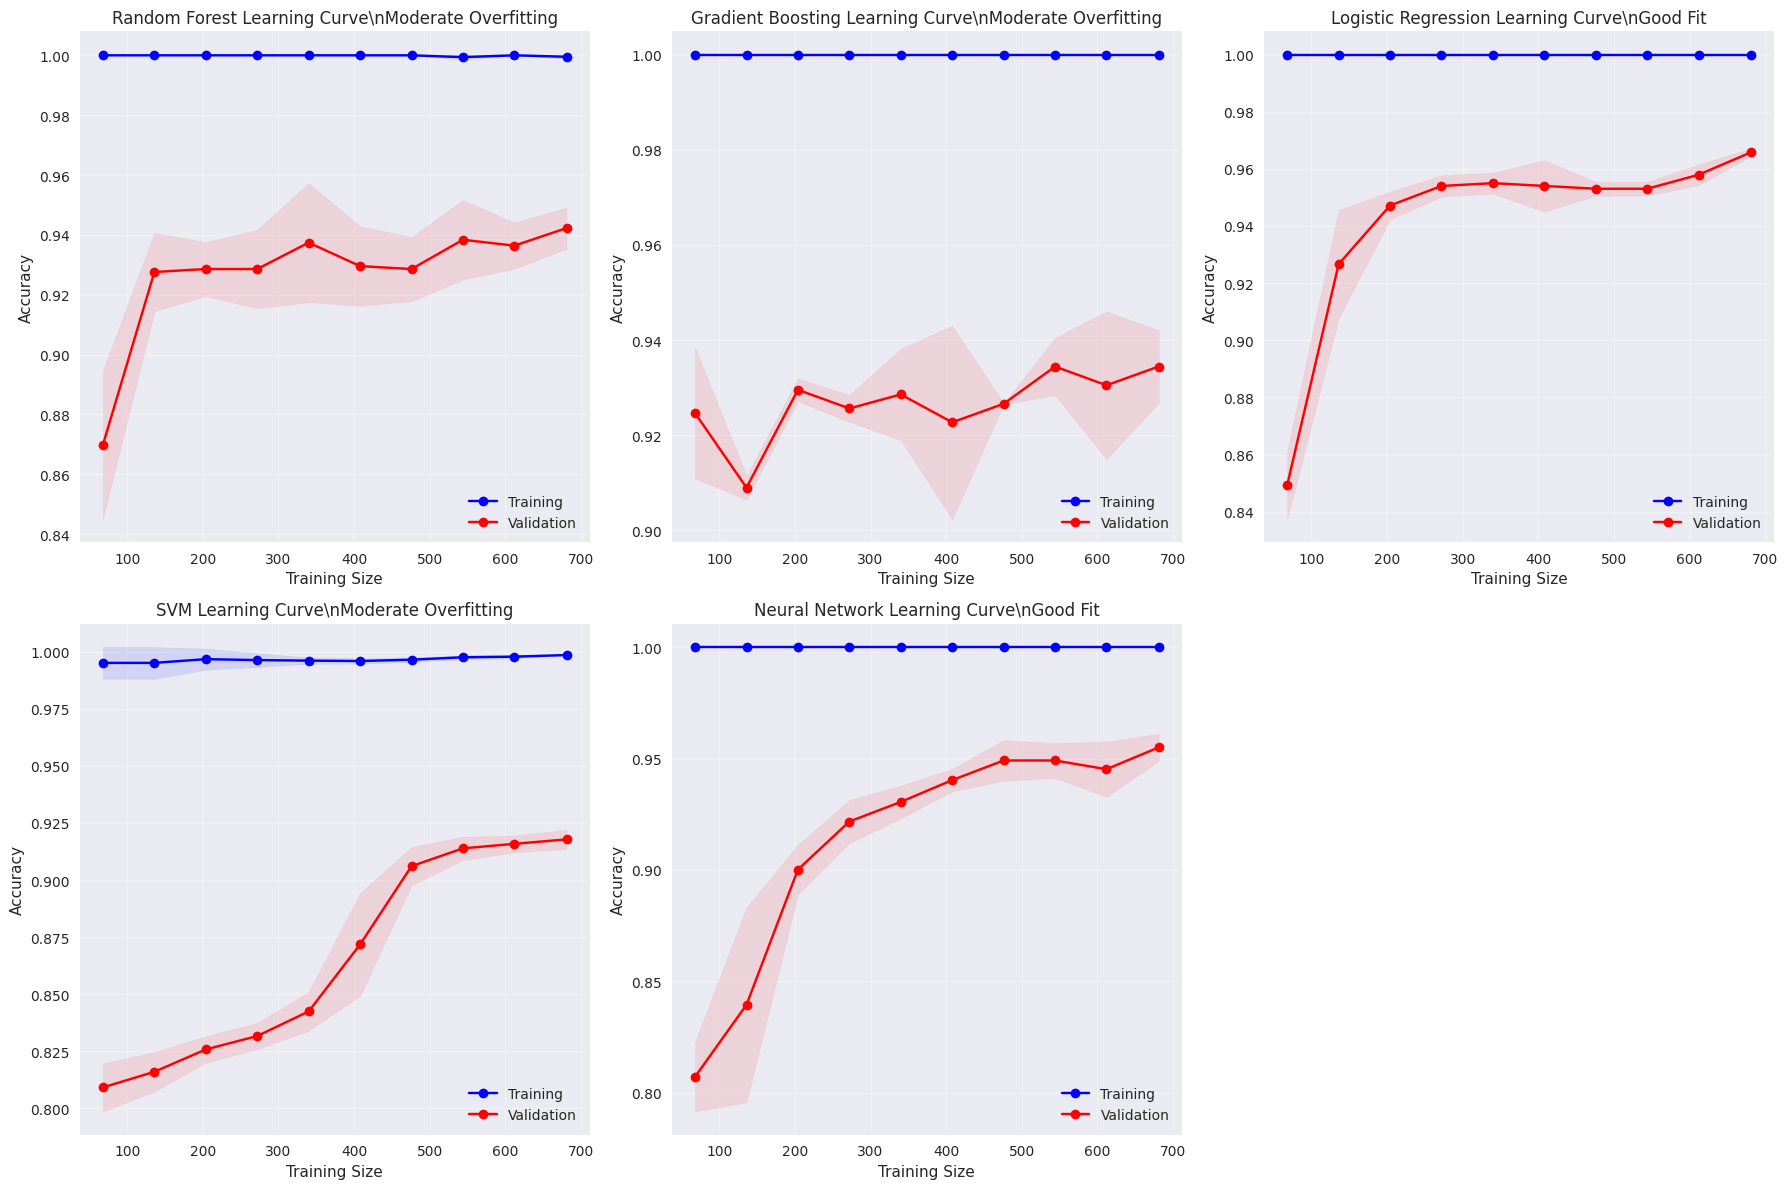

  Performance plots saved to results/plots/
\n  STEP 7: Creating feature importance heatmaps...
  Creating feature importance heatmaps...
    Creating cross-model feature importance heatmap...


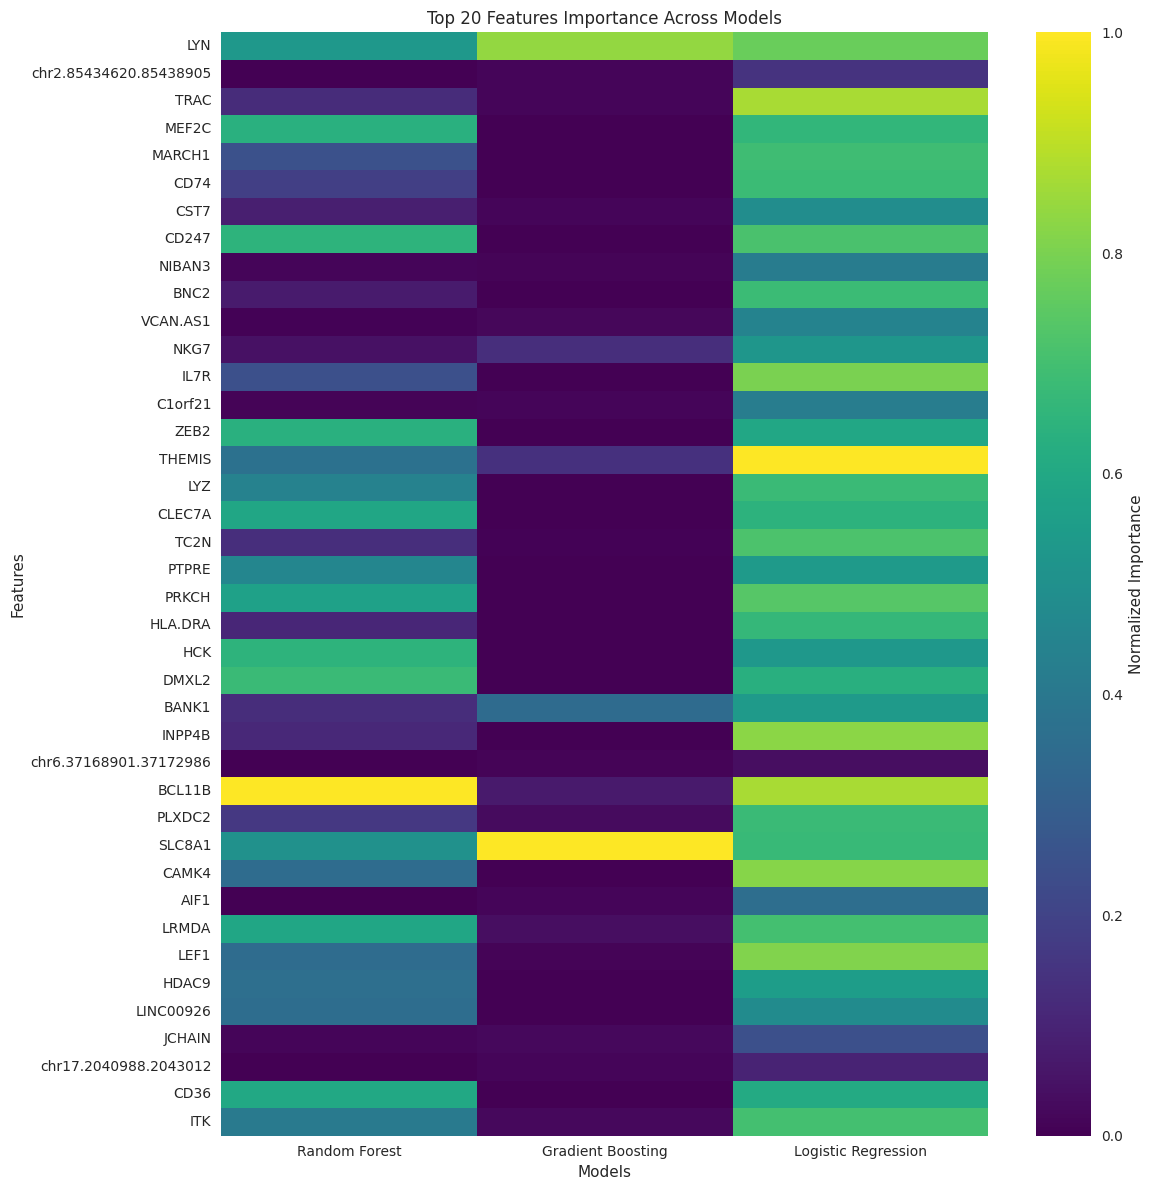

    Creating cell-type specific feature heatmap...


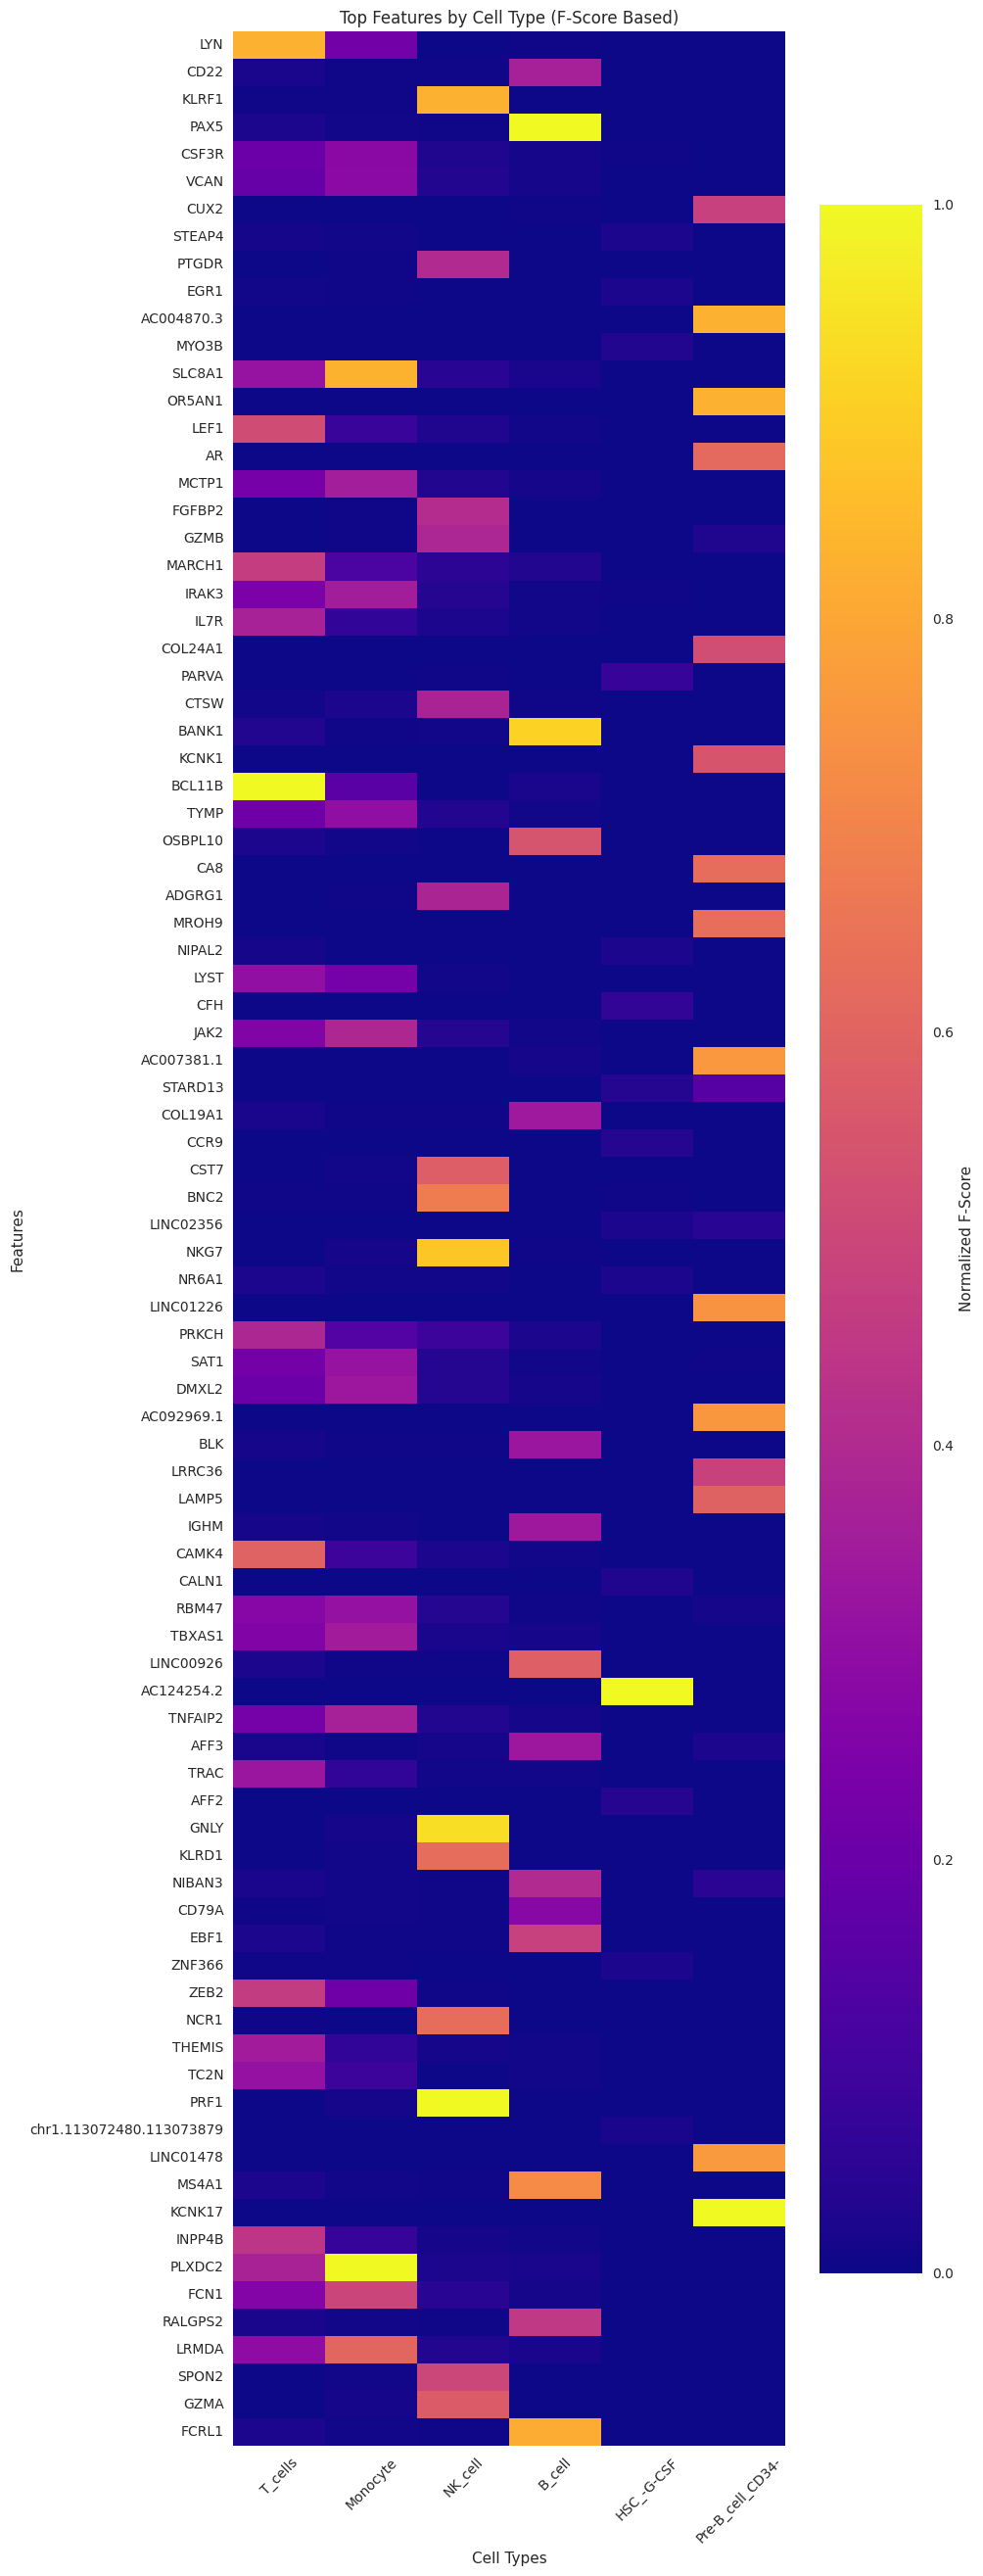

    Creating RNA vs ATAC feature distribution plot...


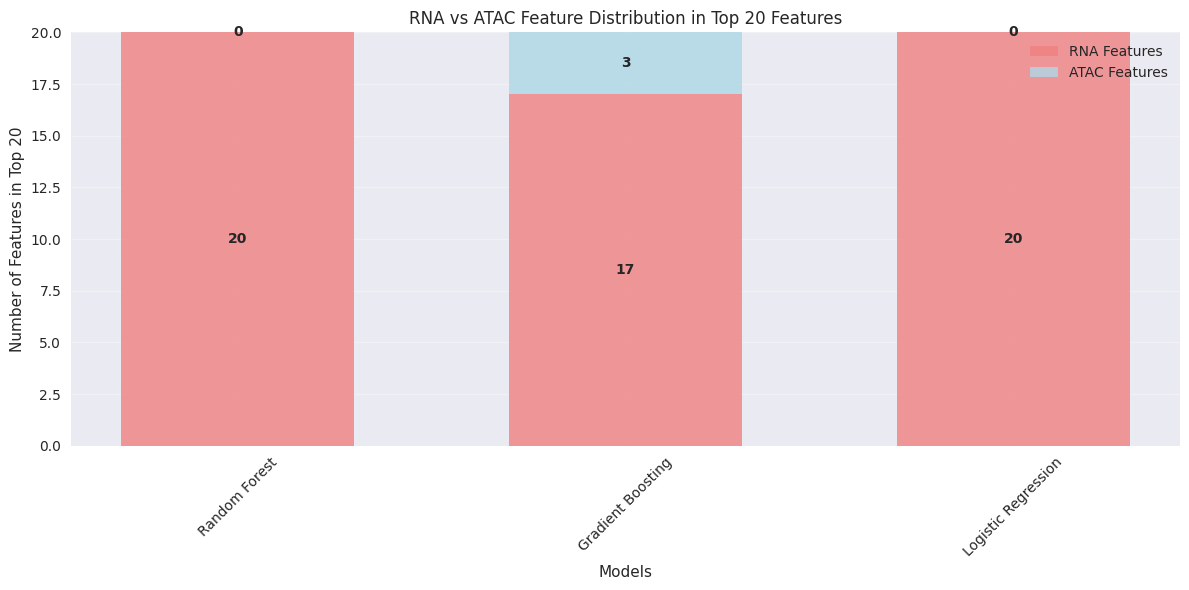

  Feature importance heatmaps saved to results/plots/
\n  STEP 8: Creating TF-Cell Type network...
  Creating TF-Cell Type network...
    Extracting actual important RNA genes from analysis...
    Selected 30 actual genes from your data:
    1. LYN
    2. CD22
    3. TRAC
    4. KLRF1
    5. MEF2C
    6. MARCH1
    7. STARD13
    8. CCR9
    9. CST7
    10. AFF2
    ... and 20 more genes


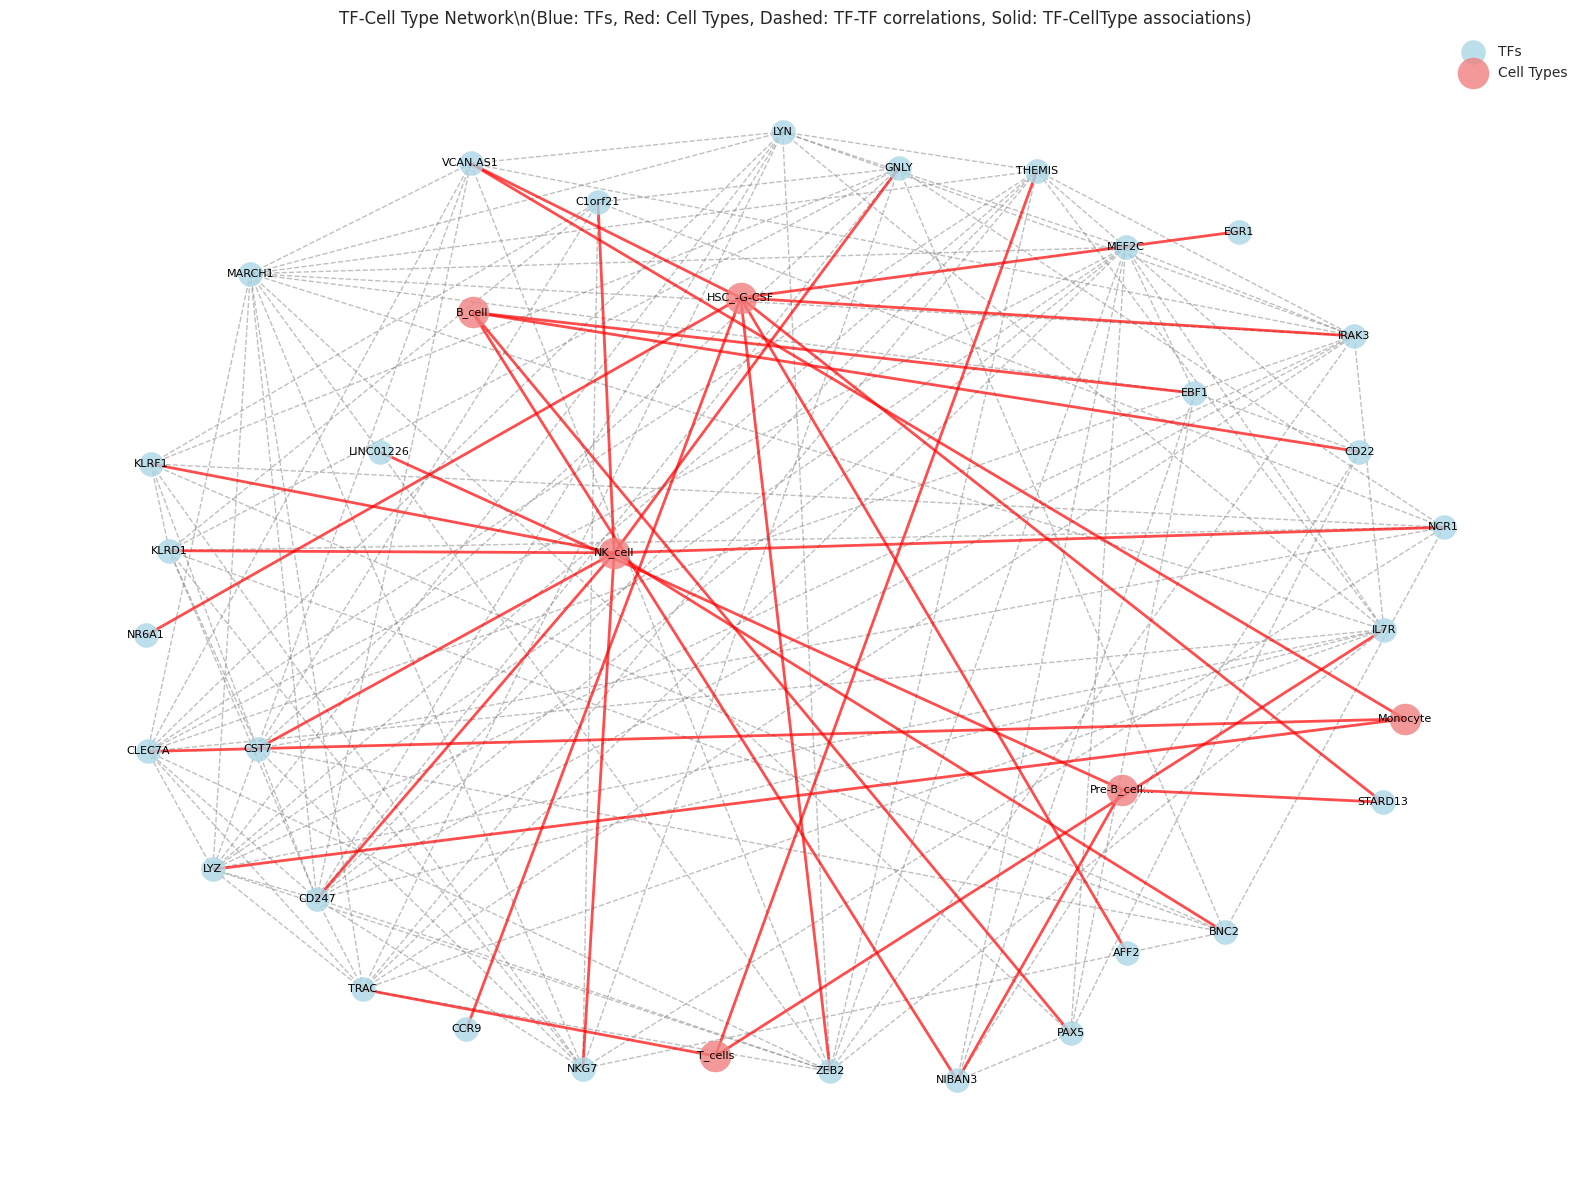

  TF-Cell Type network saved to results/plots/
\n  STEP 9: Creating TF activity analysis...
  Creating TF activity dot plots...
    Analyzing 59 unique TF features across 6 cell types


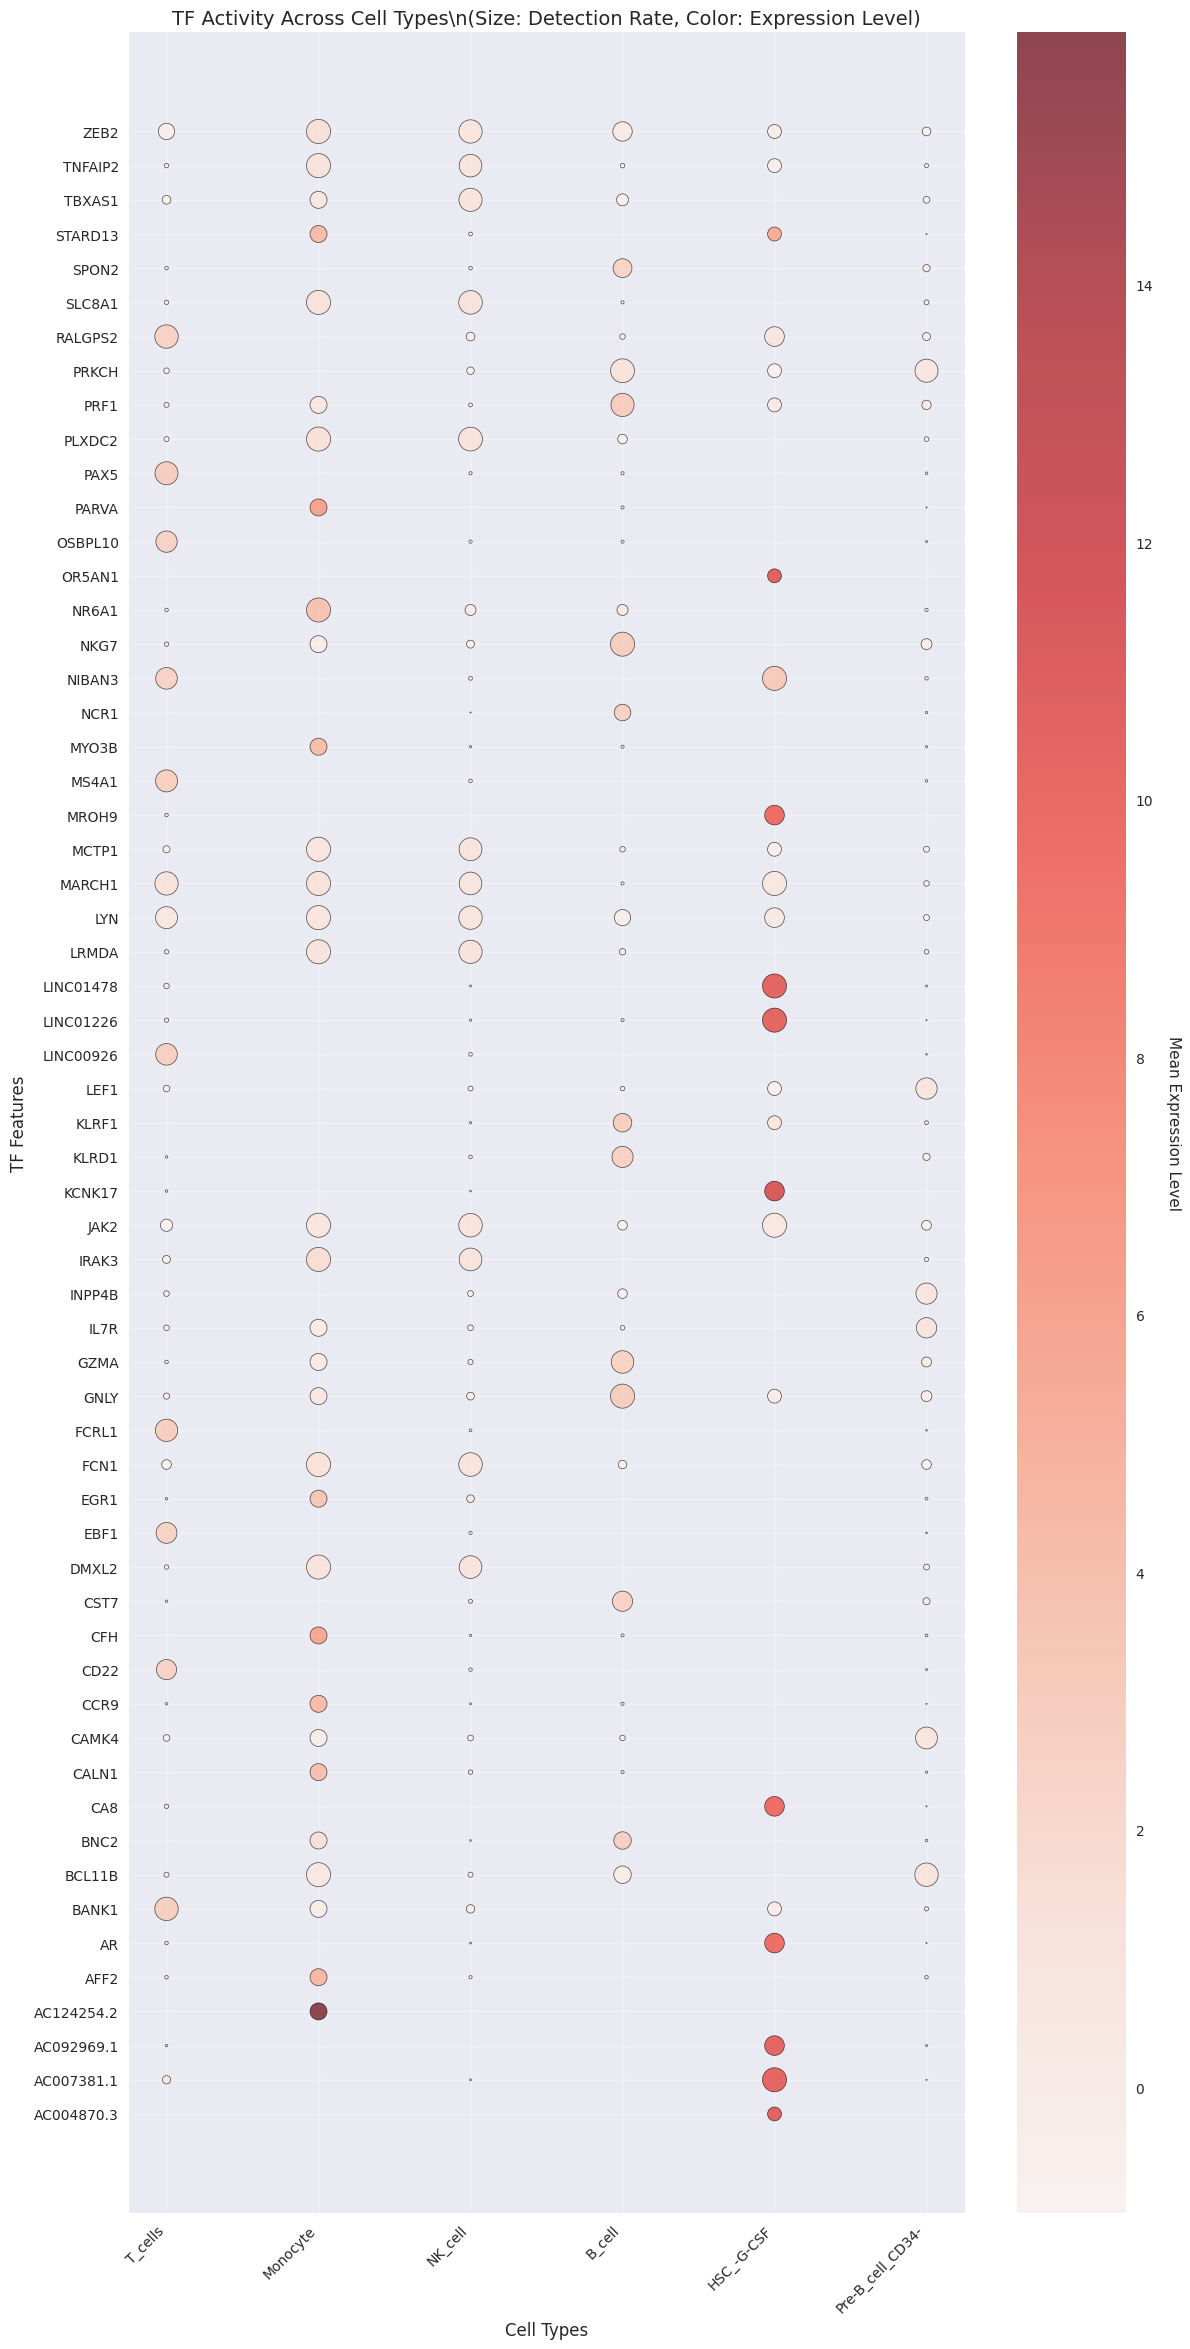

  TF activity plots saved to results/plots/
\n  STEP 10: Analyzing top TFs per cell type...
  Creating top TFs per cell type analysis...
    Analyzing T_cells...
    Analyzing Monocyte...
    Analyzing NK_cell...
    Analyzing B_cell...
    Analyzing HSC_-G-CSF...
    Analyzing Pre-B_cell_CD34-...


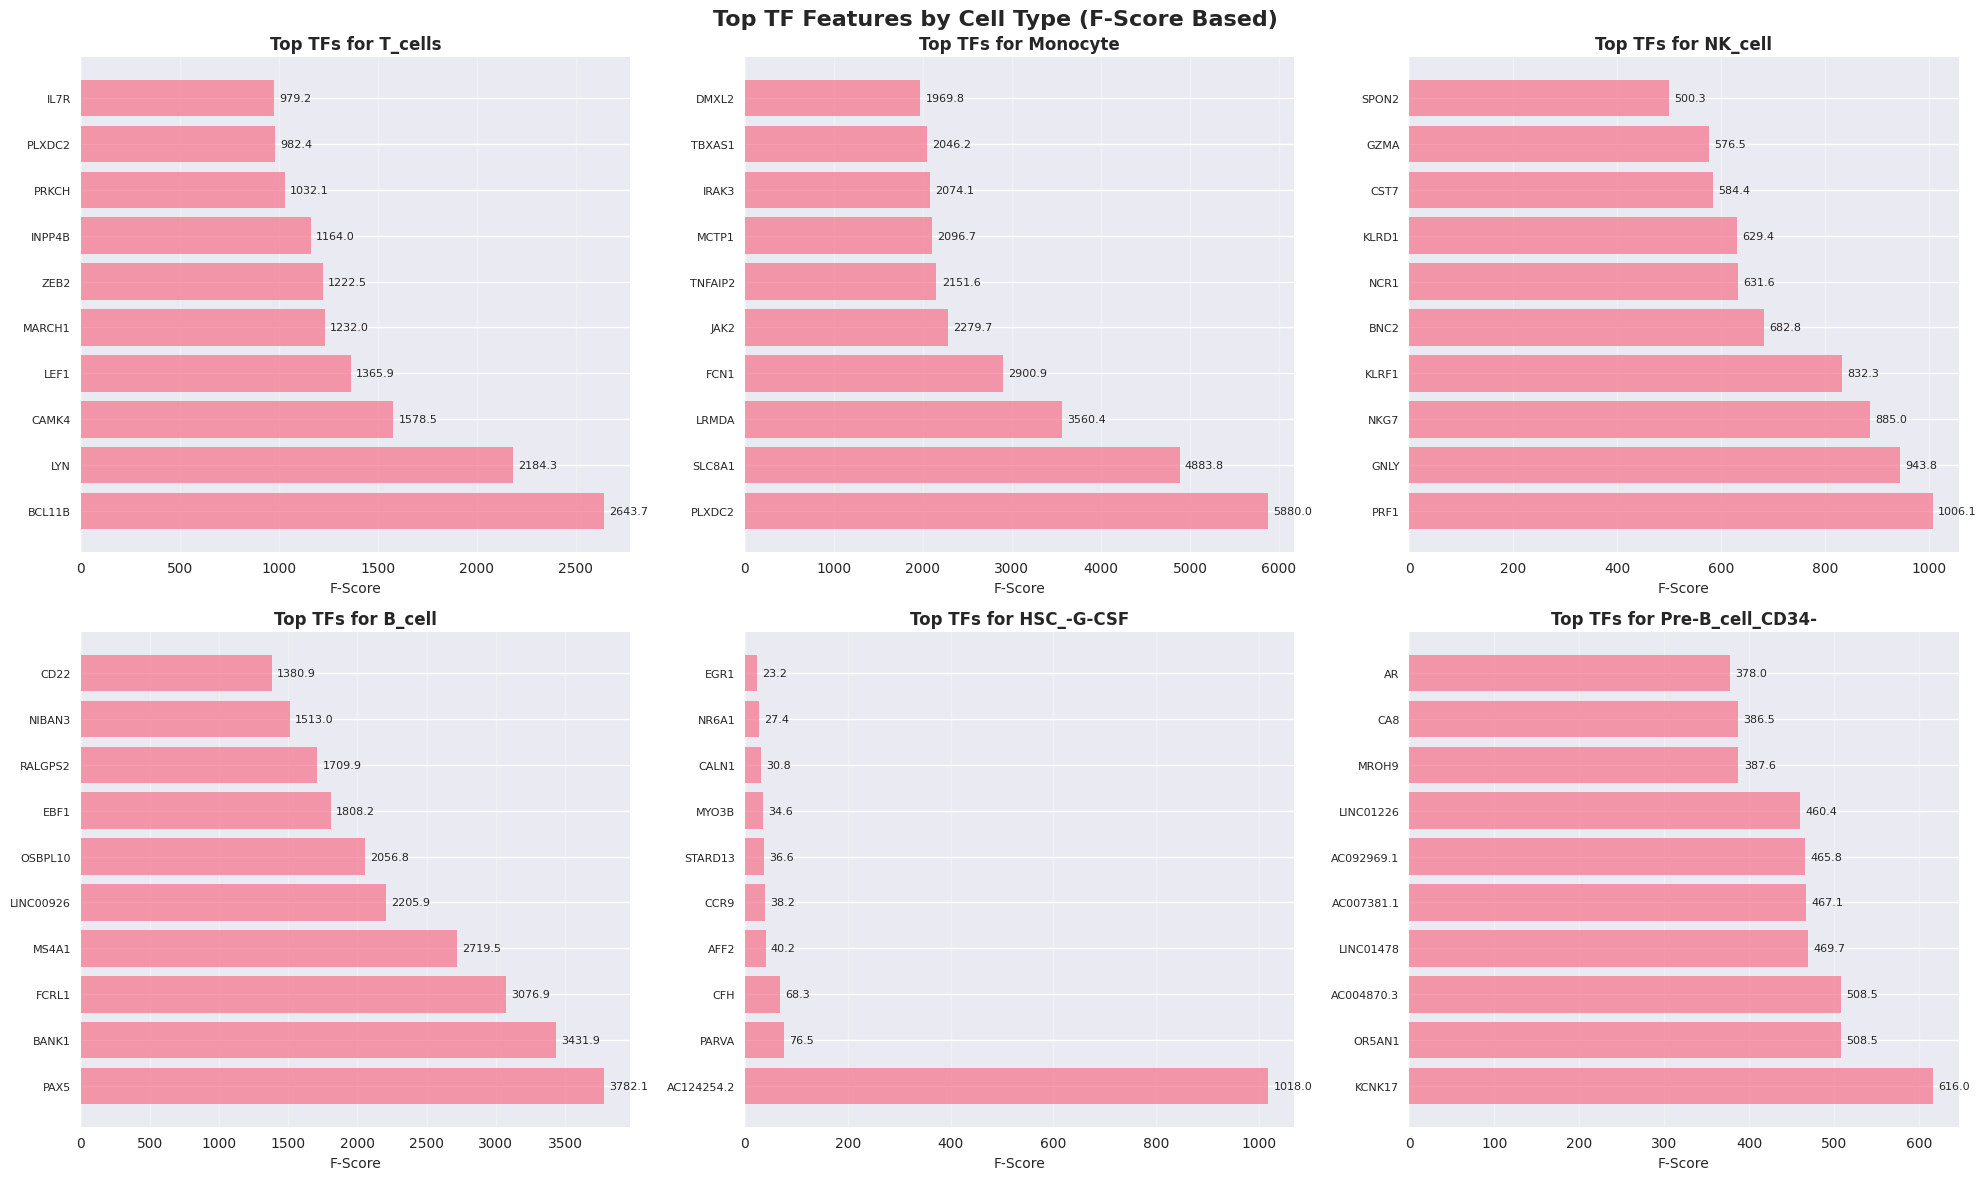

    Creating summary table...
  Top TFs analysis saved to results/plots/
\n  STEP 11: Creating timing analysis...
  Creating model timing analysis...


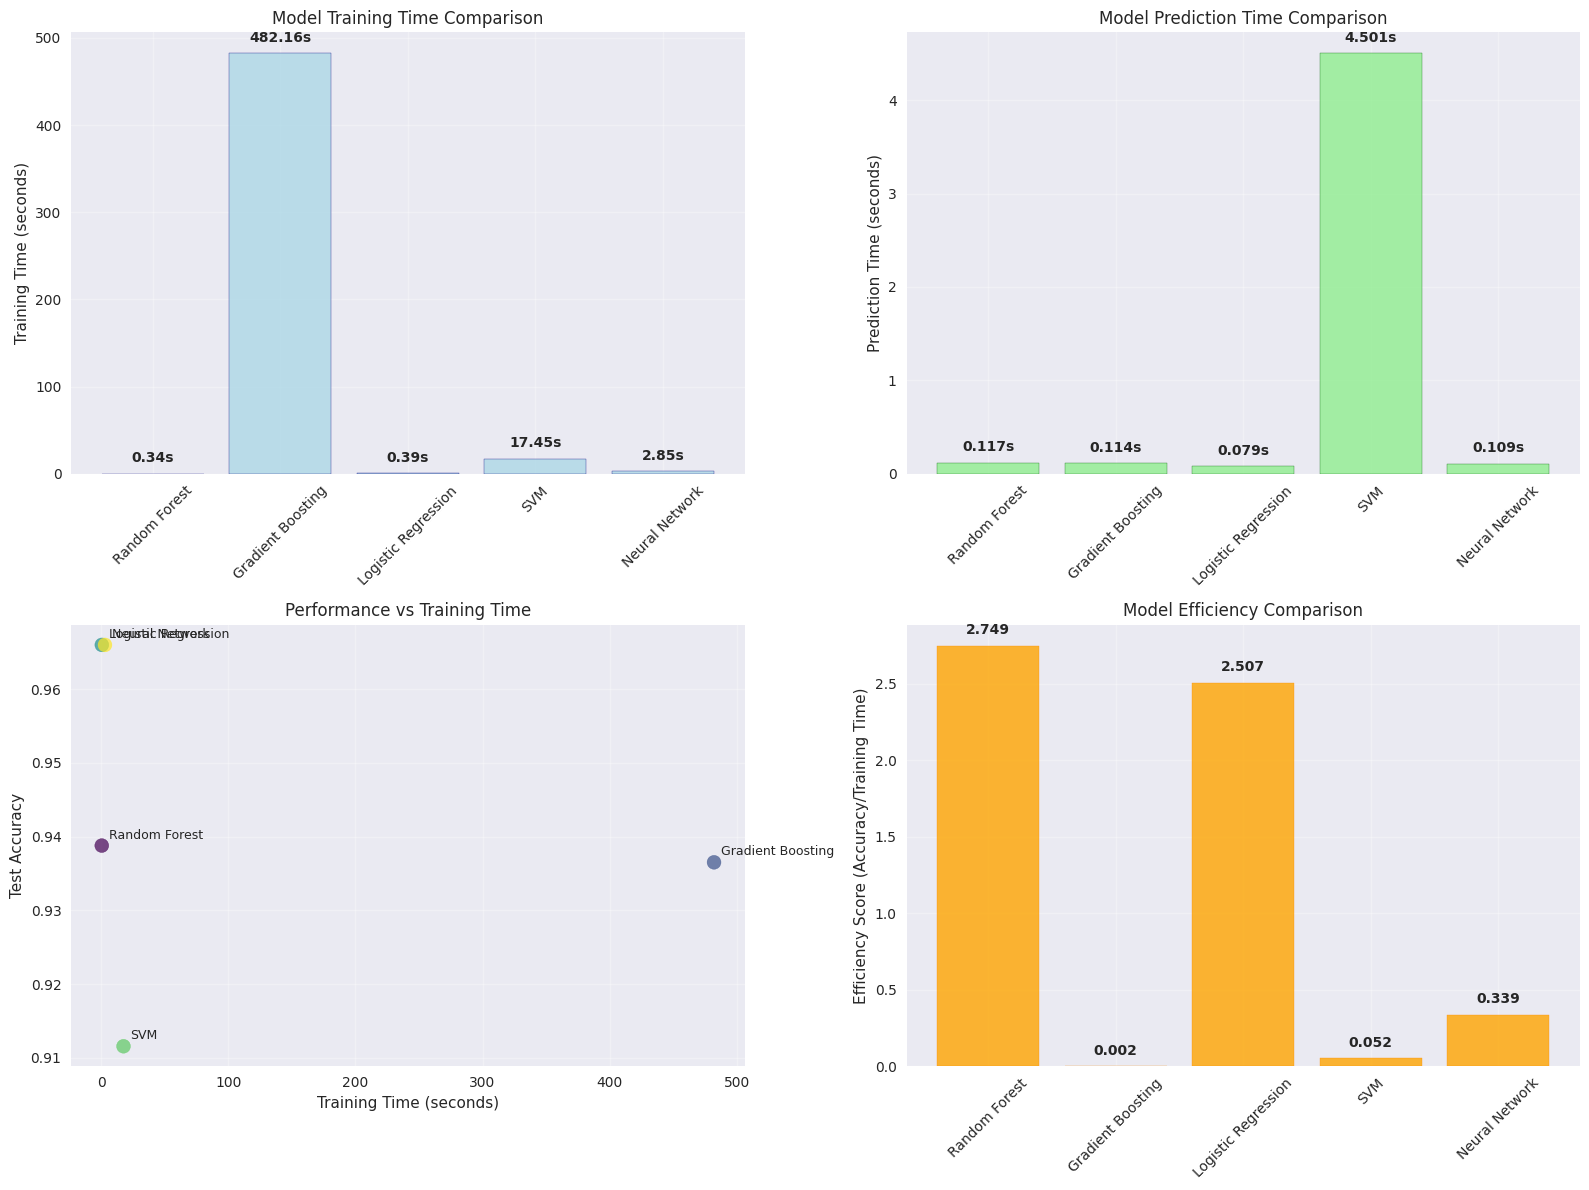

\n  Model Timing Summary:
                 Model  Training_Time_s  Prediction_Time_s  Test_Accuracy  \
0        Random Forest           0.3415             0.1171         0.9388   
1    Gradient Boosting         482.1617             0.1135         0.9365   
2  Logistic Regression           0.3853             0.0791         0.9660   
3                  SVM          17.4466             4.5007         0.9116   
4       Neural Network           2.8515             0.1086         0.9660   

   Efficiency_Score  Speed_Rank  Accuracy_Rank  Efficiency_Rank  
0            2.7494           1              3                1  
1            0.0019           5              4                5  
2            2.5072           2              1                2  
3            0.0522           4              5                4  
4            0.3388           3              1                3  
  Timing analysis saved to results/plots/
\n  STEP 12: Exporting all results...
  Exporting all results...
  💾 Savi

'\nCell-Type Classification Model Validation & Visualization Pipeline\nPreliminary result_v2.py\n\nAuthors: Research Team\nDate: 2025\nDescription: Comprehensive validation and visualization pipeline for multi-modal (RNA + ATAC) cell-type classification models\n\nPipeline Overview:\n1. Data Loading & Validation - Load processed data from R pipeline\n2. Model Building & Training - Multiple ML models with overfitting checks\n3. Model Validation - Performance metrics and cross-validation\n4. Feature Analysis - Top features identification and analysis\n5. Visualization Suite - TF networks, heatmaps, dotplots, timing analysis\n6. Results Export - Save all results for downstream analysis\n'

In [18]:
# ================================================================================
# SCRIPT EXECUTION
# ================================================================================

if __name__ == "__main__":
    # Run the complete analysis pipeline
    results = main()
    
    print("\\n🎯 Analysis complete! Check the results/ directory for all outputs.")
    print("📖 Read ANALYSIS_SUMMARY_REPORT.md for detailed findings and recommendations.")#!/usr/bin/env python3
"""
Cell-Type Classification Model Validation & Visualization Pipeline
Preliminary result_v2.py

Authors: Research Team
Date: 2025
Description: Comprehensive validation and visualization pipeline for multi-modal (RNA + ATAC) cell-type classification models

Pipeline Overview:
1. Data Loading & Validation - Load processed data from R pipeline
2. Model Building & Training - Multiple ML models with overfitting checks
3. Model Validation - Performance metrics and cross-validation
4. Feature Analysis - Top features identification and analysis
5. Visualization Suite - TF networks, heatmaps, dotplots, timing analysis
6. Results Export - Save all results for downstream analysis
"""